# Imports

In [54]:
# Maths
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.stats import binom

# Plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
sns.set_style('whitegrid')

# For geocoding
from geopy.geocoders import Nominatim # For folium maps to return centering coordinates
import osmnx as ox # To return the geometry of a target region or city
import ssl # For the certificates to make the osmnx work
ssl._create_default_https_context = ssl._create_unverified_context

# Convenience Functions

Below are some convenience functions that are helpful for the rest of the notebook.

In [2]:
# mask is a way of filtering a dataframe in a chained way
def mask(df, key, value):
    return df[df[key] == value]

pd.DataFrame.mask = mask

# apply_dtypes converts select columns from str to float values
def apply_dtypes(first, last):
    dtypes = {i: str for i in range(first)}  # first 'first' columns as strings
    dtypes.update({i: float for i in range(first, last)}) # 'last' columns is currently hard coded. Float is needed for NaNs
    return dtypes

# Returns the first (and oldest) date (assuming date is the index) of a series or DataFrame
def calculate_t0(data):
    year = int(data.head(1).index[0][:4])
    quarter = data.head(1).index[0][-2:]
    if quarter == 'Q1':
        t0 = year + 0
    elif quarter == 'Q2':
        t0 = year + 0.25
    elif quarter == 'Q3':
        t0 = year + 0.5
    elif quarter == 'Q4':
        t0 = year + 0.75
    return t0

# Returns the last (and most recent) date (assuming date is the index) of a series or DataFrame
def calculate_t_present(data):
    year = int(data.tail(1).index[0][:4])
    quarter = data.tail(1).index[0][-2:]
    if quarter == 'Q1':
        t_present = year + 0
    elif quarter == 'Q2':
        t_present = year + 0.25
    elif quarter == 'Q3':
        t_present = year + 0.5
    elif quarter == 'Q4':
        t_present = year + 0.75    
    return t_present

# Returns an array of numeric dates between t0 and t1 at a specified sample rate
def calculate_date_range(t0, t1, sample_rate):
    return np.linspace(t0, t1, int((t1-t0)*sample_rate) + 1)

# Takes in text based dates (e.g. 2022 Q4) and returns an array of decimalised dates
def convert_dates_to_numeric(data):
    dates = np.zeros(len(data))
    for i in np.arange(len(data)):
        year = int(data.index[i][:4])
        quarter = data.index[i][-2:]
        if quarter == 'Q1':
            d = year + 0
        elif quarter == 'Q2':
            d = year + 0.25
        elif quarter == 'Q3':
            d = year + 0.5
        elif quarter == 'Q4':
            d = year + 0.75
        dates[i] = d
    return dates

# Read in Data

### Datasets included in this analysis:
- **VEH1153**: Vehicles registered for the first time by body type and fuel type.

- **VEH1103**: Licensed vehicles at the end of the quarter by body type and fuel type.

- **LSOA Lookup Data**: Links the LSOA and LAD names and codes from the 2011 and 2021 census.

- **df_VEH0125**: Historical private vehicle registration by LSOA (quarterly).

- **df_VEH0145**: Historical private plug-in vehicle registration by LSOA (quarterly)

- **Distribution Substation Customer Data**: Number of customers

- **Distribution Substation Spatial Data**: Boundaries and Locations

- **LSOA Spatial Data**: Boundaries

- **LSOA Number of Households**: Number of households in each LSOA

### VEH1153: Vehicles registered for the first time by body type and fuel type

In [3]:
drop_cols_veh1153 = [
    'Units',
]

veh1153 = (
    pd.read_excel(
        "../../data/vehicle_data/veh1153.ods", 
        engine="odf", 
        sheet_name='VEH1153a_RoadUsing', 
        skiprows=4, 
        na_values=['[c]', '[x]']
    )
    .rename(
        columns={
            'Geography [note 3]': 'Geography',
            'Date Interval [note 4]': 'Date Interval',
            'Date [note 4]': 'Date',
            'Other vehicles [note 3]': 'Other vehicles',
            'Gas [note 5]': 'Gas',
            'Other fuel types [note 6]': 'Other fuel types',
            'Plug-in [note 7]': 'Plug-in',
            'Zero emission [note 8]': 'Zero emission'
        }
    )
    .query("BodyType == 'Cars' and Units == 'Thousands'")
    .drop(drop_cols_veh1153, axis=1)
)

# Convert units from Thousands to real counts
veh1153.iloc[:, 4:] = veh1153.iloc[:, 4:]*1000

# Approximate the number of ICE vehicles given the total, plug-in and fuel-cell electric vehicles
veh1153['ICE'] = veh1153['Total'] - veh1153['Plug-in'] - veh1153['Fuel cell electric']

# Remove bracketed text from Dates
veh1153['Date'] = veh1153['Date'].str.replace(r"\(.*\)","", regex=True).str.strip()

veh1153.head()

Geography Date Interval  Date BodyType     Petrol    Diesel  \
374   England        Annual  2001     Cars  1874649.0  405214.0   
375   England        Annual  2002     Cars  1793879.0  563102.0   
376   England        Annual  2003     Cars  1679322.0  641920.0   
377   England        Annual  2004     Cars  1524998.0  749242.0   
378   England        Annual  2005     Cars  1343752.0  794699.0   

     Hybrid electric (petrol)  Hybrid electric (diesel)  \
374                     604.0                       3.0   
375                     270.0                       0.0   
376                     351.0                       0.0   
377                    1442.0                       0.0   
378                    4997.0                       3.0   

     Plug-in hybrid electric (petrol)  Plug-in hybrid electric (diesel)  \
374                               0.0                               0.0   
375                               0.0                               0.0   
376                               0.0                               0.0   
377                               0.0                               0.0   
378                               0.0                               0.0   

     Battery electric  Range extended electric  Fuel cell electric     Gas  \
374              81.0                      0.0                 0.0  1954.0   
375              58.0                      0.0                 1.0  2311.0   
376              39.0                      0.0                 3.0  3086.0   
377              90.0                      0.0                 2.0  1681.0   
378             223.0                      0.0                 4.0   482.0   

     Other fuel types      Total  Plug-in  Zero emission        ICE  
374               7.0  2282512.0     81.0           81.0  2282431.0  
375               3.0  2359624.0     58.0           59.0  2359565.0  
376               6.0  2324727.0     39.0           42.0  2324685.0  
377               8.0  2277463.0     90.0           92.0  2277371.0  
378              13.0  2144173.0    223.0          227.0  2143946.0

### VEH1103: Licensed vehicles at the end of the quarter by body type and fuel type

In [4]:
drop_cols_veh1103 = [
    'Units',
]

veh1103 = (
    pd.read_excel(
        "../../data/vehicle_data/veh1103.ods", 
        engine="odf", 
        sheet_name='VEH1103a_RoadUsing', 
        skiprows=4, 
        na_values=['[c]', '[x]']
    )
    .rename(
        columns={
            'Geography [note 3]': 'Geography',
            'Gas [note 4]': 'Gas',
            'Other fuel types [note 5]': 'Other fuel types',
            'Plug-in [note 6]': 'Plug-in',
            'Zero emission [note 7]': 'Zero emission'
        }
    )
    .query("BodyType == 'Cars' and Units == 'Thousands'")
    .drop(drop_cols_veh1103, axis=1)
)

# Convert units from Thousands to real counts
veh1103.iloc[:, 3:] = veh1103.iloc[:, 3:]*1000

# Approximate the number of ICE vehicles given the total, plug-in and fuel-cell electric vehicles
veh1103['ICE'] = veh1103['Total'] - veh1103['Plug-in'] - veh1103['Fuel cell electric']

# Remove bracketed text from Dates
veh1103['Date'] = veh1103['Date'].str.replace(r"\(.*\)","", regex=True).str.strip()

veh1103.head()

Geography     Date BodyType      Petrol     Diesel  \
72   England  1994 Q4     Cars  16694257.0  1313637.0   
73   England  1995 Q4     Cars  16635739.0  1573698.0   
74   England  1996 Q4     Cars  17149424.0  1811387.0   
75   England  1997 Q4     Cars  17505628.0  2031080.0   
76   England  1998 Q4     Cars  17744318.0  2247998.0   

    Hybrid electric (petrol)  Hybrid electric (diesel)  \
72                       0.0                       0.0   
73                       0.0                       0.0   
74                       0.0                       0.0   
75                       0.0                       0.0   
76                       0.0                       0.0   

    Plug-in hybrid electric (petrol)  Plug-in hybrid electric (diesel)  \
72                               0.0                               0.0   
73                               0.0                               0.0   
74                               0.0                               0.0   
75                               0.0                               0.0   
76                               0.0                               0.0   

    Battery electric  Range extended electric  Fuel cell electric     Gas  \
72              81.0                      0.0                 0.0  1543.0   
73              61.0                      0.0                 0.0  2518.0   
74              79.0                      0.0                 0.0  3587.0   
75             101.0                      0.0                 0.0  5577.0   
76             140.0                      0.0                 0.0  8650.0   

    Other fuel types       Total  Plug-in  Zero emission         ICE  
72             192.0  18009710.0     81.0           81.0  18009629.0  
73             121.0  18212137.0     61.0           61.0  18212076.0  
74             107.0  18964584.0     79.0           79.0  18964505.0  
75             104.0  19542490.0    101.0          101.0  19542389.0  
76             100.0  20001206.0    140.0          140.0  20001066.0

### LSOA Lookup Data

In [5]:
LAD = 'Bath and North East Somerset' # Target Local Authority District

In [6]:
lsoa_lookup = pd.read_csv('../../data/spatial_data/lsoa_data/LSOA_(2011)_to_LSOA_(2021)_to_Local_Authority_District_(2022)_Lookup_for_England_and_Wales_(Version_2).csv')
lsoa_lookup.head()

LSOA11CD                   LSOA11NM   LSOA21CD                   LSOA21NM  \
0  E01000001        City of London 001A  E01000001        City of London 001A   
1  E01000002        City of London 001B  E01000002        City of London 001B   
2  E01000003        City of London 001C  E01000003        City of London 001C   
3  E01000005        City of London 001E  E01000005        City of London 001E   
4  E01000006  Barking and Dagenham 016A  E01000006  Barking and Dagenham 016A   

  CHGIND    LAD22CD               LAD22NM LAD22NMW  ObjectId  
0      U  E09000001        City of London      NaN         1  
1      U  E09000001        City of London      NaN         2  
2      U  E09000001        City of London      NaN         3  
3      U  E09000001        City of London      NaN         4  
4      U  E09000002  Barking and Dagenham      NaN         5

### Historical Total Vehicle Registration Data for LSOAs

In [7]:
v_lsoa = (
    pd.read_csv('../../data/vehicle_data/df_VEH0125.csv', dtype = apply_dtypes(5, 57), na_values=['[c]', '[x]'])
    .query("BodyType == 'Cars' and Keepership == 'Private' and LicenceStatus == 'Licensed'")
    .drop(columns = ['BodyType', 'Keepership', 'LicenceStatus', 'LSOA11NM']) # Drop Filtered columns (As all same value)
    .merge(lsoa_lookup.loc[:, ['LSOA11CD', 'LAD22NM']], on='LSOA11CD', how='outer')
    .loc[lambda x: x['LAD22NM'] == LAD] # Filter for target Local Authority (BNES)
    .drop(columns = ['LAD22NM'])
    .set_index('LSOA11CD')
)

# Drop duplicate rows
v_lsoa = v_lsoa[~v_lsoa.index.duplicated(keep='first')]

v_lsoa.head()

2022 Q4  2022 Q3  2022 Q2  2022 Q1  2021 Q4  2021 Q3  2021 Q2  \
LSOA11CD                                                                   
E01014370    361.0    353.0    357.0    352.0    369.0    390.0    382.0   
E01014371    502.0    512.0    507.0    524.0    517.0    524.0    524.0   
E01014372    495.0    507.0    506.0    509.0    513.0    508.0    506.0   
E01014373    753.0    754.0    770.0    768.0    775.0    762.0    773.0   
E01014374    752.0    762.0    759.0    756.0    746.0    750.0    741.0   

           2021 Q1  2020 Q4  2020 Q3  ...  2012 Q1  2011 Q4  2011 Q3  2011 Q2  \
LSOA11CD                              ...                                       
E01014370    380.0    371.0    372.0  ...    390.0    397.0    391.0    393.0   
E01014371    530.0    523.0    512.0  ...    537.0    552.0    546.0    557.0   
E01014372    508.0    500.0    479.0  ...    548.0    553.0    556.0    552.0   
E01014373    740.0    749.0    759.0  ...    680.0    674.0    690.0    688.0   
E01014374    739.0    727.0    718.0  ...    632.0    627.0    632.0    637.0   

           2011 Q1  2010 Q4  2010 Q3  2010 Q2  2010 Q1  2009 Q4  
LSOA11CD                                                         
E01014370    384.0    389.0    406.0    378.0    384.0    386.0  
E01014371    552.0    540.0    538.0    549.0    547.0    557.0  
E01014372    571.0    561.0    588.0    604.0    595.0    591.0  
E01014373    695.0    692.0    684.0    696.0    692.0    703.0  
E01014374    634.0    633.0    637.0    628.0    627.0    641.0  

[5 rows x 53 columns]

### Historical Electric Vehicle Registration Data for LSOAs by Propulsion Type

In [8]:
ev_lsoa = (
    pd.read_csv('../../data/vehicle_data/df_VEH0145.csv', dtype = apply_dtypes(4, 56), na_values=['[c]', '[x]'])
    .query("Keepership == 'Private'")
    .drop(columns = ['Keepership', 'LSOA11NM']) # Drop Filtered columns (As all same value)
    .merge(lsoa_lookup.loc[:, ['LSOA11CD', 'LAD22NM']], on='LSOA11CD', how='outer')
    .loc[lambda x: x['LAD22NM'] == LAD]
    .drop(columns = ['LAD22NM'])
    .set_index('LSOA11CD')
)

ev_lsoa.head()

Fuel  2022 Q4  2022 Q3  2022 Q2  \
LSOA11CD                                                                 
E01014370                  Battery electric      9.0      8.0      7.0   
E01014370  Plug-in hybrid electric (petrol)      NaN      NaN      NaN   
E01014370                             Total     13.0     12.0     10.0   
E01014371                  Battery electric      5.0      5.0      5.0   
E01014371  Plug-in hybrid electric (diesel)      NaN      NaN      NaN   

           2022 Q1  2021 Q4  2021 Q3  2021 Q2  2021 Q1  2020 Q4  ...  2014 Q1  \
LSOA11CD                                                         ...            
E01014370      8.0      8.0      6.0      NaN      NaN      NaN  ...      0.0   
E01014370      NaN      NaN      NaN      NaN      NaN      NaN  ...      0.0   
E01014370     11.0     11.0      8.0      6.0      NaN      NaN  ...      0.0   
E01014371      5.0      NaN      NaN      NaN      NaN      NaN  ...      0.0   
E01014371      NaN      NaN      0.0      0.0      0.0      0.0  ...      0.0   

           2013 Q4  2013 Q3  2013 Q2  2013 Q1  2012 Q4  2012 Q3  2012 Q2  \
LSOA11CD                                                                   
E01014370      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
E01014370      0.0      0.0      0.0      0.0      NaN      NaN      0.0   
E01014370      0.0      0.0      0.0      0.0      NaN      NaN      0.0   
E01014371      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
E01014371      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

           2012 Q1  2011 Q4  
LSOA11CD                     
E01014370      0.0      0.0  
E01014370      0.0      0.0  
E01014370      0.0      0.0  
E01014371      0.0      0.0  
E01014371      0.0      0.0  

[5 rows x 46 columns]

This now needs to be disaggregated by propulsion type.

#### Historical BEV Registration Data for LSOAs

In [9]:
bev_lsoa = (
    ev_lsoa
    .query("Fuel == 'Battery electric' or Fuel.isnull()") # Fill in missing rows
    .drop(columns = ['Fuel']) # Drop Fuel column as all identical
)

# Drop duplicate rows
bev_lsoa = bev_lsoa[~bev_lsoa.index.duplicated(keep='first')]

bev_lsoa.head()

2022 Q4  2022 Q3  2022 Q2  2022 Q1  2021 Q4  2021 Q3  2021 Q2  \
LSOA11CD                                                                   
E01014370      9.0      8.0      7.0      8.0      8.0      6.0      NaN   
E01014371      5.0      5.0      5.0      5.0      NaN      NaN      NaN   
E01014372      7.0      5.0      5.0      5.0      NaN      5.0      5.0   
E01014373     10.0     12.0     11.0     11.0     11.0      9.0      7.0   
E01014374     20.0     17.0     18.0     18.0     15.0     15.0     10.0   

           2021 Q1  2020 Q4  2020 Q3  ...  2014 Q1  2013 Q4  2013 Q3  2013 Q2  \
LSOA11CD                              ...                                       
E01014370      NaN      NaN      NaN  ...      0.0      0.0      0.0      0.0   
E01014371      NaN      NaN      NaN  ...      0.0      0.0      0.0      0.0   
E01014372      5.0      6.0      5.0  ...      0.0      0.0      0.0      0.0   
E01014373      7.0      7.0      7.0  ...      0.0      0.0      0.0      0.0   
E01014374      8.0      5.0      5.0  ...      NaN      NaN      NaN      NaN   

           2013 Q1  2012 Q4  2012 Q3  2012 Q2  2012 Q1  2011 Q4  
LSOA11CD                                                         
E01014370      0.0      0.0      0.0      0.0      0.0      0.0  
E01014371      0.0      0.0      0.0      0.0      0.0      0.0  
E01014372      0.0      0.0      0.0      0.0      0.0      0.0  
E01014373      0.0      0.0      0.0      0.0      0.0      0.0  
E01014374      NaN      NaN      NaN      NaN      NaN      NaN  

[5 rows x 45 columns]

#### Historical PHEV Registration Data for LSOAs

In [10]:
phev_lsoa = (
    ev_lsoa
    .query("Fuel == 'Plug-in hybrid electric (petrol)' or Fuel.isnull()") # Fill in missing rows
    .drop(columns = ['Fuel']) # Drop Fuel column as all identical
)

# Drop duplicate rows
phev_lsoa = phev_lsoa[~phev_lsoa.index.duplicated(keep='first')]

phev_lsoa.head()

2022 Q4  2022 Q3  2022 Q2  2022 Q1  2021 Q4  2021 Q3  2021 Q2  \
LSOA11CD                                                                   
E01014370      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
E01014371      NaN      5.0      NaN      NaN      NaN      NaN      NaN   
E01014372      5.0      NaN      NaN      NaN      NaN      6.0      5.0   
E01014373      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
E01014374     12.0     11.0     10.0      9.0      8.0      7.0      5.0   

           2021 Q1  2020 Q4  2020 Q3  ...  2014 Q1  2013 Q4  2013 Q3  2013 Q2  \
LSOA11CD                              ...                                       
E01014370      NaN      NaN      NaN  ...      0.0      0.0      0.0      0.0   
E01014371      NaN      NaN      NaN  ...      0.0      0.0      0.0      0.0   
E01014372      NaN      NaN      NaN  ...      0.0      0.0      0.0      0.0   
E01014373      NaN      NaN      NaN  ...      0.0      0.0      0.0      0.0   
E01014374      NaN      NaN      NaN  ...      0.0      0.0      0.0      0.0   

           2013 Q1  2012 Q4  2012 Q3  2012 Q2  2012 Q1  2011 Q4  
LSOA11CD                                                         
E01014370      0.0      NaN      NaN      0.0      0.0      0.0  
E01014371      0.0      0.0      0.0      0.0      0.0      0.0  
E01014372      0.0      0.0      0.0      0.0      0.0      0.0  
E01014373      0.0      0.0      0.0      0.0      0.0      0.0  
E01014374      0.0      0.0      0.0      0.0      0.0      0.0  

[5 rows x 45 columns]

#### Historical EV Registration Data for LSOAs

In [11]:
total_ev_lsoa = (
    ev_lsoa
    .query("Fuel == 'Total' or Fuel.isnull()") # Fill in missing rows
    .drop(columns = ['Fuel']) # Drop Fuel column as all identical
)

# Drop duplicate rows
total_ev_lsoa = total_ev_lsoa[~total_ev_lsoa.index.duplicated(keep='first')]

total_ev_lsoa.head()

2022 Q4  2022 Q3  2022 Q2  2022 Q1  2021 Q4  2021 Q3  2021 Q2  \
LSOA11CD                                                                   
E01014370     13.0     12.0     10.0     11.0     11.0      8.0      6.0   
E01014371     10.0     11.0     10.0     10.0      7.0      7.0      7.0   
E01014372     12.0      9.0      9.0      8.0      8.0     11.0     10.0   
E01014373     14.0     15.0     15.0     15.0     15.0     13.0     11.0   
E01014374     34.0     30.0     30.0     29.0     24.0     23.0     16.0   

           2021 Q1  2020 Q4  2020 Q3  ...  2014 Q1  2013 Q4  2013 Q3  2013 Q2  \
LSOA11CD                              ...                                       
E01014370      NaN      NaN      NaN  ...      0.0      0.0      0.0      0.0   
E01014371      6.0      NaN      NaN  ...      NaN      0.0      0.0      0.0   
E01014372      9.0      9.0      7.0  ...      0.0      0.0      0.0      0.0   
E01014373     11.0     10.0      9.0  ...      0.0      0.0      0.0      0.0   
E01014374     13.0     10.0      9.0  ...      NaN      NaN      NaN      NaN   

           2013 Q1  2012 Q4  2012 Q3  2012 Q2  2012 Q1  2011 Q4  
LSOA11CD                                                         
E01014370      0.0      NaN      NaN      0.0      0.0      0.0  
E01014371      0.0      0.0      0.0      0.0      0.0      0.0  
E01014372      0.0      0.0      0.0      0.0      0.0      0.0  
E01014373      0.0      0.0      0.0      0.0      0.0      0.0  
E01014374      NaN      NaN      NaN      NaN      NaN      NaN  

[5 rows x 45 columns]

#### Historical ICE Registration Data for LSOAs

The difference between the total vehicle and EV registration is assumed to be the ICE registration.

In [12]:
ice_lsoa = v_lsoa.subtract(total_ev_lsoa)
ice_lsoa = ice_lsoa[ice_lsoa.columns[::-1]]
ice_lsoa.head()

2022 Q4  2022 Q3  2022 Q2  2022 Q1  2021 Q4  2021 Q3  2021 Q2  \
LSOA11CD                                                                   
E01014370    348.0    341.0    347.0    341.0    358.0    382.0    376.0   
E01014371    492.0    501.0    497.0    514.0    510.0    517.0    517.0   
E01014372    483.0    498.0    497.0    501.0    505.0    497.0    496.0   
E01014373    739.0    739.0    755.0    753.0    760.0    749.0    762.0   
E01014374    718.0    732.0    729.0    727.0    722.0    727.0    725.0   

           2021 Q1  2020 Q4  2020 Q3  ...  2012 Q1  2011 Q4  2011 Q3  2011 Q2  \
LSOA11CD                              ...                                       
E01014370      NaN      NaN      NaN  ...    390.0    397.0      NaN      NaN   
E01014371    524.0      NaN      NaN  ...    537.0    552.0      NaN      NaN   
E01014372    499.0    491.0    472.0  ...    548.0    553.0      NaN      NaN   
E01014373    729.0    739.0    750.0  ...    680.0    674.0      NaN      NaN   
E01014374    726.0    717.0    709.0  ...      NaN      NaN      NaN      NaN   

           2011 Q1  2010 Q4  2010 Q3  2010 Q2  2010 Q1  2009 Q4  
LSOA11CD                                                         
E01014370      NaN      NaN      NaN      NaN      NaN      NaN  
E01014371      NaN      NaN      NaN      NaN      NaN      NaN  
E01014372      NaN      NaN      NaN      NaN      NaN      NaN  
E01014373      NaN      NaN      NaN      NaN      NaN      NaN  
E01014374      NaN      NaN      NaN      NaN      NaN      NaN  

[5 rows x 53 columns]

# "Global" Variables

In [15]:
RANDOM_SEED = 42

sample_rate = 4 # Quarterly
region = 'England'

# Inital estimates for BEV and PHEV lifetimes
bev_lifetime = 12 # Years
phev_lifetime = 15 # Years

horizon = 2050 # How far into the future we're looking

ice_ban = 2030 # The year in which the sale of new ICE vehicles is banned in the UK
phev_ban = 2035 # The year in which the sale of new Hybrid vehicles is banned in the UK

# Interpolate Missing Registration Data

- Historical registration data is not reported if the number of registered vehicles in an LSOA is: $0 < n < 5$.
- Therefore, missing registration data is interpolated in order to better capture trends in EV registration.

In [16]:
# Interpolates missing registration data
def interpolate_registration_data(data, sample_rate):
    def interpolate_col(col):
        dates = calculate_date_range(calculate_t0(col), calculate_t_present(col), sample_rate)
        mask = ~col.isna().values
        if mask.any():
            xp = dates[mask]
            fp = col[mask]
            x = dates
            interpolated = np.round(np.interp(x, xp, fp))
            return pd.Series(data=interpolated, index=col.index)
        else:
            return pd.Series(data=np.nan, index=col.index)
    
    interpolated_df = data.apply(interpolate_col, axis=0)

    interpolated_df = interpolated_df.fillna(0)
    
    return interpolated_df

In [17]:
bev_lsoa_i = interpolate_registration_data(bev_lsoa.T.iloc[::-1], sample_rate=sample_rate)
phev_lsoa_i = interpolate_registration_data(phev_lsoa.T.iloc[::-1], sample_rate=sample_rate)
total_ev_lsoa_i = interpolate_registration_data(total_ev_lsoa.T.iloc[::-1], sample_rate=sample_rate)
total_lsoa_i = interpolate_registration_data(v_lsoa.T.iloc[::-1], sample_rate=sample_rate)

# Doing this afterwards with interpolated data reduces the number of NaNs
ice_lsoa_i = total_lsoa_i.subtract(total_ev_lsoa_i)
ice_lsoa_i.tail()

LSOA11CD  E01014370  E01014371  E01014372  E01014373  E01014374  E01014375  \
2021 Q4       358.0      510.0      505.0      760.0      722.0      827.0   
2022 Q1       341.0      514.0      501.0      753.0      727.0      820.0   
2022 Q2       347.0      497.0      497.0      755.0      729.0      814.0   
2022 Q3       341.0      501.0      498.0      739.0      732.0      815.0   
2022 Q4       348.0      492.0      483.0      739.0      718.0      784.0   

LSOA11CD  E01014376  E01014377  E01014379  E01014380  ...  E01014478  \
2021 Q4       979.0      806.0     1320.0      722.0  ...      469.0   
2022 Q1       992.0      806.0     1324.0      723.0  ...      459.0   
2022 Q2       986.0      802.0     1310.0      727.0  ...      451.0   
2022 Q3       965.0      788.0     1310.0      731.0  ...      452.0   
2022 Q4       968.0      788.0     1308.0      720.0  ...      455.0   

LSOA11CD  E01014479  E01014480  E01014481  E01014482  E01014483  E01014484  \
2021 Q4       656.0      549.0      382.0      598.0      441.0      383.0   
2022 Q1       654.0      546.0      377.0      604.0      437.0      377.0   
2022 Q2       651.0      544.0      369.0      600.0      434.0      390.0   
2022 Q3       652.0      545.0      382.0      600.0      431.0      397.0   
2022 Q4       651.0      535.0      387.0      596.0      424.0      396.0   

LSOA11CD  E01033078  E01033079  E01033080  
2021 Q4      1015.0      716.0      582.0  
2022 Q1       999.0      708.0      592.0  
2022 Q2       983.0      703.0      585.0  
2022 Q3       974.0      684.0      570.0  
2022 Q4       968.0      692.0      582.0  

[5 rows x 115 columns]

To illustrate the process of linear interpolation, here's an example for an LSOA with missing registration data:

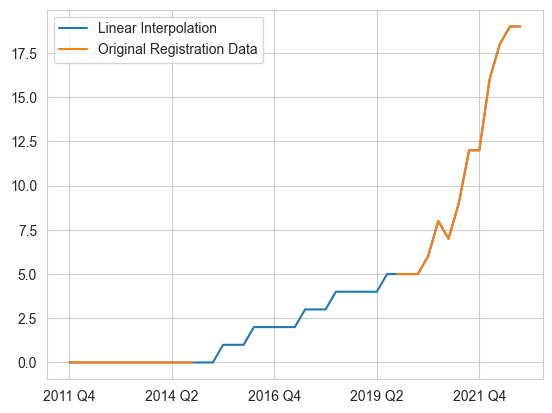

In [505]:
fig, ax = plt.subplots()
bev_lsoa_i.iloc[:, 16].plot(ax=ax, label='Linear Interpolation')
bev_lsoa.T.iloc[::-1].iloc[:, 16].plot(ax=ax, label='Original Registration Data')
plt.legend()
plt.show()

# Approximate Vehicle Retirement Rates

- I am assuming that the retirement rate of ICE vehicles is equal to the quarterly number of retired ICEs divided by the total number of registered ICEs. This represents the proportion of the ICE stock that retire each quarter. The inverse of this would give an estimate for the average lifespan of an ICE. This works out at around 18 years.

- I should probably calculate retirement rates for each LSOA. For instance, one LSOA might have a high throughput of vehicles, whilst another might retain vehicles for longer.

- However, this is quite hard to do with the data available since I can only approximate the number of new vehicles at the LSOA level (there is no primary data source for this)

In [18]:
# Number of ICE vehicles currently registered in the "region"
n_ice = veh1103.loc[(veh1103['Geography'] == region), 'ICE'].iloc[-1]
n_ice

26459296.0

In [19]:
# ICE Retirements
ice_retirements = (
    veh1153.loc[(veh1153['Geography'] == region) & (veh1153['Date Interval'] == 'Quarterly')].set_index('Date').loc[:, 'ICE'] - 
    veh1103.loc[(veh1103['Geography'] == region)].set_index('Date').loc[:, 'ICE'].diff()).mean() # Per Quarter
ice_retirement_rate = ice_retirements/n_ice
ice_retirement_rate

0.013699838888672334

In [20]:
bev_retirement_rate = 1/(4*bev_lifetime)
bev_retirement_rate

0.020833333333333332

In [21]:
phev_retirement_rate = 1/(4*phev_lifetime)
phev_retirement_rate

0.016666666666666666

# Estimate New Vehicle Registrations in each LSOA

- The rolling averaging of the new vehicle approximations helps to eliminate any "high-frequency" noise in the data and makes the interpolation of sales shares more reliable.

- In this case, I'm mostly interested in the most recent value for new vehicles since this is what the forecast trajectory for sales share is based off.

- Although it's not probabilistic, in order to make this work, I need to assume a mean retirement rate to estimate the number of new registrations in each LSOA every quarter. This is not ideal, but it keeps this method relatively simple.

In [22]:
rolling_average_window = 8 # Quarters

new_bev_lsoa = bev_lsoa_i.diff().add(bev_lsoa_i*bev_retirement_rate) # Approximate new BEV registrations per quarter
new_bev_lsoa[new_bev_lsoa < 0] = 0
smoothed_new_bev_lsoa = new_bev_lsoa.rolling(rolling_average_window).mean() # Calculate rolling average

new_phev_lsoa = phev_lsoa_i.diff().add(phev_lsoa_i*phev_retirement_rate) # Approximate new PHEV registrations per quarter
new_phev_lsoa[new_phev_lsoa < 0] = 0
smoothed_new_phev_lsoa = new_phev_lsoa.rolling(rolling_average_window).mean()

new_ice_lsoa = ice_lsoa_i.diff().add(ice_lsoa_i*ice_retirement_rate) # Approximate new ICE registrations per quarter
new_ice_lsoa[new_ice_lsoa < 0] = 0
smoothed_new_ice_lsoa = new_ice_lsoa.rolling(rolling_average_window).mean()

smoothed_new_vehicles_lsoa = sum([smoothed_new_ice_lsoa, smoothed_new_bev_lsoa, smoothed_new_phev_lsoa])
smoothed_new_ev_lsoa = sum([smoothed_new_bev_lsoa, smoothed_new_phev_lsoa])

# Forecasting the Sales Share for Each Propulsion Type

Here's a description of the `calculate_sales_share` function:

1. `target`: Represents the number of new vehicle registrations of the target type over time.

2. `parent`: Represents the total number of new vehicle registrations for the parent vehicle type over the same time period (e.g. EV is the parent vehicle type of BEV and PHEV).

3. `ban`: The date at which legislative action or a ban comes into effect.

4. `value_at_ban`: The value to be assigned to sales shares after the ban date. In the absence of data, it is set to 0.5, representing a 50-50 share between the child vehicle types (e.g. BEVs and PHEVs).

5. `sales_share = target.divide(parent)`: This line calculates the sales share by dividing the target registrations by the parent registrations for each date. This gives the proportion of the target vehicle type relative to the parent for each time point.

6. The subsequent lines of code handle cases where sales shares are missing (NaN) or equal to 0. In such cases, the last entry of the sales share (at the latest date) is set to 0.5. This approach assumes that between the current date and the legislative ban, there's still a chance for regions to see a rise in vehicle ownership even if no registrations of the target type were recorded in the past.

7. `sales_share = sales_share.fillna(0)`: Any remaining NaNs (resulting from dividing by zero) in the sales share data are filled with 0. This step is done to avoid issues with division by zero.

8. The function converts the historical dates in the sales share DataFrame to numeric values using the `convert_dates_to_numeric` function.

9. `date_range = calculate_date_range(calculate_t0(sales_share), t1=horizon, sample_rate=sample_rate)`: A date range is generated from the earliest date in the sales share data to the horizon (future time point) at a specified sample rate.

10. `sales_share['Date_numeric'] = dates`: The converted date values are added as a new column ('Date_numeric') in the sales share DataFrame.

11. The DataFrame is then set to be indexed by the numeric dates, and it is reindexed to include all dates in the date range, ensuring all time points are accounted for.

12. Sales shares at the ban date are assigned the value specified in `value_at_ban`, representing either a 0 (if the vehicle type is banned) or 1 (if it is allowed).

13. The function performs linear interpolation to fill in missing sales share values for dates between the available data points. This step estimates sales shares for dates in the future.

14. The resulting DataFrame with sales share estimates for all dates is returned.

In [23]:
def calculate_sales_share(target, parent, ban, value_at_ban):
    sales_share = target.divide(parent) # Target = Vehicle type, parent = Parent vehicle type

    # The following sets any cell that contains NaN or 0 to 0.5 share as the last entry. 
    # Between the current date and the legislative ban there is still a chance that a region could see a rise in vehicle ownership
    # Despite there being no registrations of those vehicle types in the past.

    sales_share.iloc[-1] = sales_share.iloc[-1].fillna(0.5)
    sales_share.iloc[-1][sales_share.iloc[-1] == 0] = 0.5

    sales_share = sales_share.fillna(0) # 0.0/0.0 = NaN. Therefore, I replace the NaNs with 0 (Need to review this)
    
    dates = convert_dates_to_numeric(sales_share) # Historical Dates
    date_range = calculate_date_range(calculate_t0(sales_share), t1=horizon, sample_rate=sample_rate) # Current and Future Dates

    sales_share['Date_numeric'] = dates
    sales_share = sales_share.set_index('Date_numeric')
    sales_share = sales_share.reindex(date_range)

    # Linear Interpolation
    sales_share.loc[ban, :] = value_at_ban # 0 if banned vehicle type, 1 if beneficiary.
    sales_share = sales_share.interpolate()
    return sales_share

In [24]:
# ev_sales_share_lsoa = calculate_sales_share(smoothed_new_ev_lsoa, smoothed_new_vehicles_lsoa, ice_ban, 1)
ice_sales_share_lsoa = calculate_sales_share(smoothed_new_ice_lsoa, smoothed_new_vehicles_lsoa, ice_ban, 0)
# bev_sales_share_lsoa = calculate_sales_share(smoothed_new_bev_lsoa, smoothed_new_ev_lsoa, phev_ban, 1)
phev_sales_share_lsoa = calculate_sales_share(smoothed_new_phev_lsoa, smoothed_new_ev_lsoa, phev_ban, 0)

<Axes: title={'center': 'Share of new EVs that are PHEVs in each LSOA'}, xlabel='Date_numeric'>

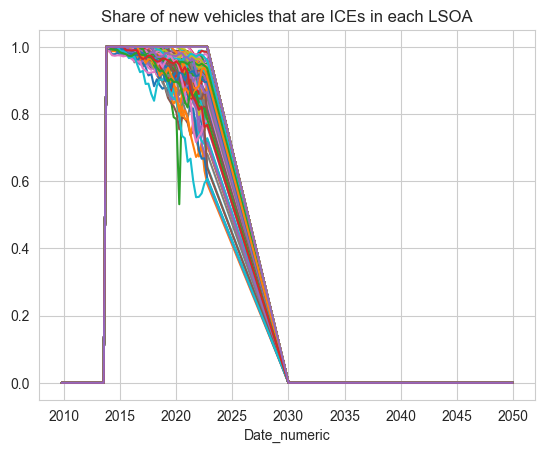

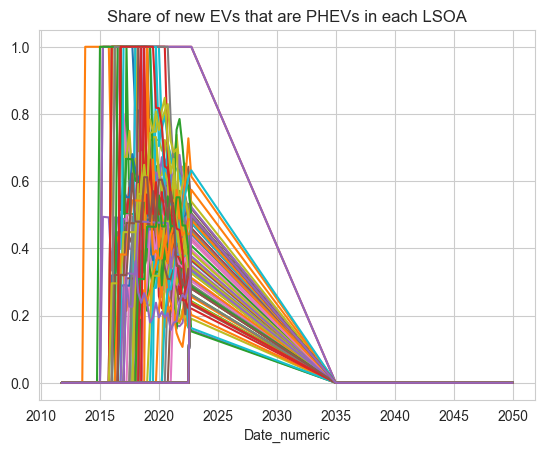

In [25]:
ice_sales_share_lsoa.plot(legend=False, title='Share of new vehicles that are ICEs in each LSOA')
phev_sales_share_lsoa.plot(legend=False, title='Share of new EVs that are PHEVs in each LSOA')

# Incorporating Anticipatory behaviour

- This code models anticipatory behavior for ICE and PHEV vehicles, and then adjusts the sales shares of these vehicle types during a 10-year anticipatory period. 
- It uses an exponential growth function to model the changes in sales shares, and the adjusted sales shares are used to plot the changes in the shares of ICEs, EVs, PHEVs, and BEVs in each LSOA during the anticipatory period. 
- The code is helpful in understanding how vehicle sales shares may be influenced by anticipated changes in regulations or vehicle bans.
- *I currently have no idea what the parameters of this anticipatory component should be.*

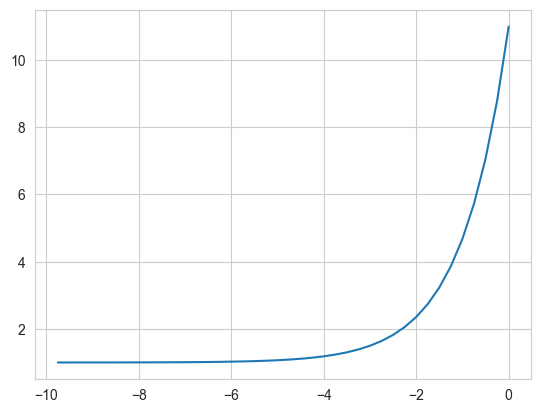

In [26]:
anticipatory_period = 10

x = np.linspace(-(anticipatory_period - (1/sample_rate)), 0, 40) # 10 years (40 quarters)

# ICE Anticipatory Parameters
a = 10
b = 1

y_ice = a * np.exp(b * x) + 1

# PHEV Anticipatory Parameters
c = 10
d = 1

y_phev = c * np.exp(d * x) + 1

plt.plot(x, y_ice)

<Axes: title={'center': 'Share of new EVs that are BEVs in each LSOA (including anticipatory behaviour)'}, xlabel='Date_numeric'>

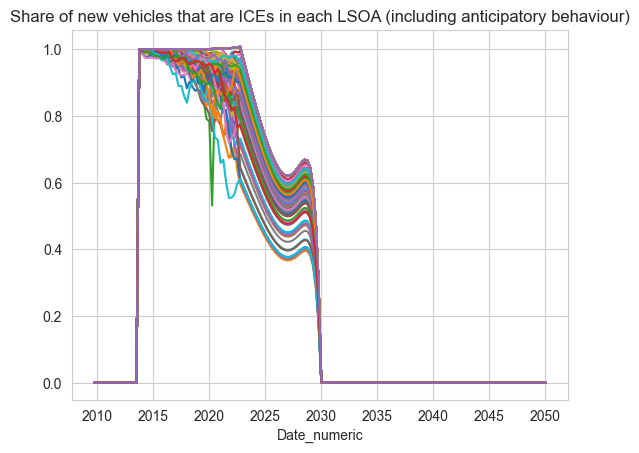

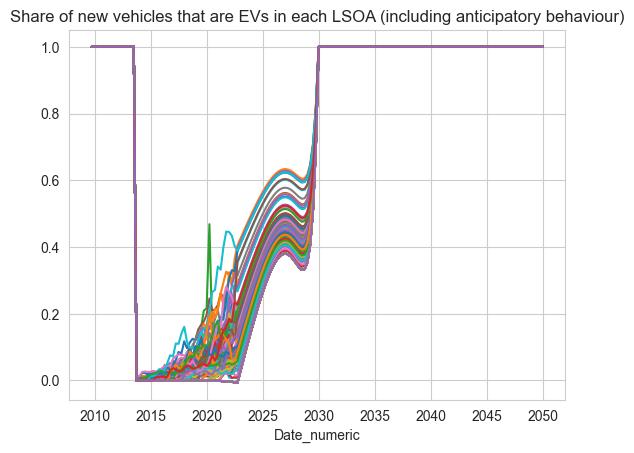

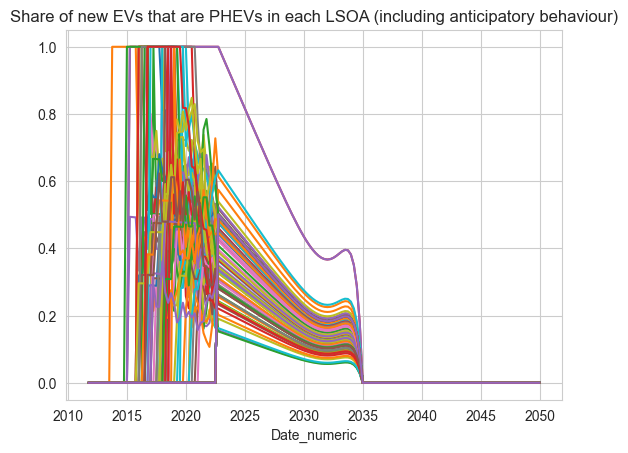

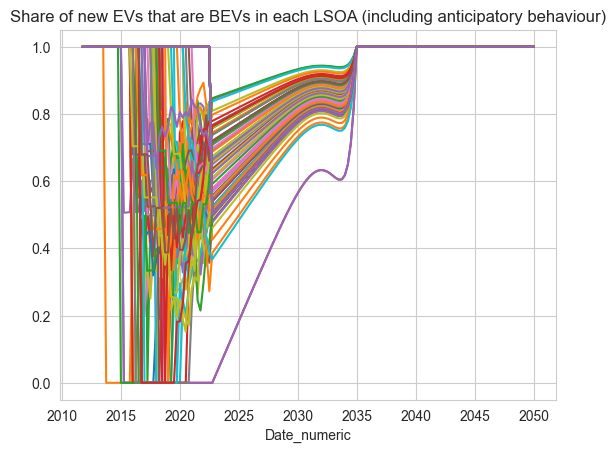

In [27]:
ice_sales_share_lsoa.loc[ice_ban - (anticipatory_period - (1/sample_rate)) : ice_ban] = ice_sales_share_lsoa.loc[ice_ban - (anticipatory_period - (1/sample_rate)) : ice_ban].multiply(y_ice, axis=0)
ev_sales_share_lsoa = 1 - ice_sales_share_lsoa

phev_sales_share_lsoa[phev_ban - (anticipatory_period - (1/sample_rate)) : phev_ban] = phev_sales_share_lsoa.loc[phev_ban - (anticipatory_period - (1/sample_rate)) : phev_ban].multiply(y_phev, axis=0)
bev_sales_share_lsoa = 1 - phev_sales_share_lsoa

ice_sales_share_lsoa.plot(legend=False, title='Share of new vehicles that are ICEs in each LSOA (including anticipatory behaviour)')
ev_sales_share_lsoa.plot(legend=False, title='Share of new vehicles that are EVs in each LSOA (including anticipatory behaviour)')
phev_sales_share_lsoa.plot(legend=False, title='Share of new EVs that are PHEVs in each LSOA (including anticipatory behaviour)')
bev_sales_share_lsoa.plot(legend=False, title='Share of new EVs that are BEVs in each LSOA (including anticipatory behaviour)')

# Probabilistic Modelling of Future Vehicle Adoption

Trying to account for the uncertainty in overal new vehicle registrations.

In [28]:
# Bayesian Stuff
import pymc as pm
import arviz as az

### Modelling Uncertainty in New Vehicle Registrations

Since the forecasted number of BEVs, PHEVs and ICEs are all calculated based on their share of new vehicle registrations (not ideal in terms of model flexibility, but it simplifies things down), if I want to be probabilistic about the number of new BEVs, PHEVs and ICEs entering the system (target LSOA in this case) a good place to start would be to learn the mean and variance of overall (historical) new vehicle registrations.

Weirdly, these new registrations were estimated from the total number of registered vehicles by assuming the retirement rates for BEVs, PHEVs and ICEs. Not ideal, but a neccesary assumption to make this methodology work.

<Axes: >

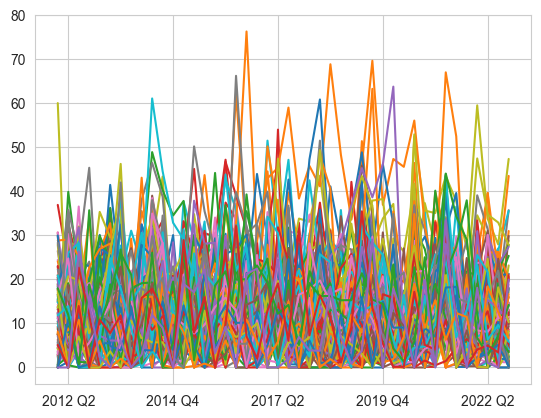

In [29]:
new_vehicles_lsoa = sum([new_ice_lsoa, new_bev_lsoa, new_phev_lsoa])
new_vehicles_lsoa.plot(legend=False)

In this case, the choice of target_lsoa is completely arbitrary. However, to test this approach works, I've chosen an LSOA that has a reasonable number of BEVs and PHEVs to start with (e.g. `E01014399`).

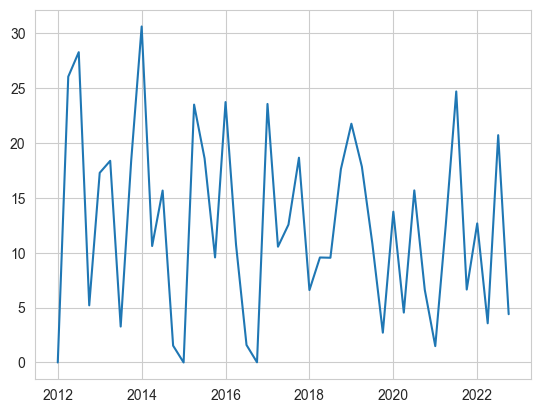

In [205]:
target_lsoa = 'E01014452'

target_lsoa_data = new_vehicles_lsoa[target_lsoa].dropna().to_numpy()
plt.plot(convert_dates_to_numeric(new_vehicles_lsoa.dropna()), target_lsoa_data)

### Modelling new vehicle registrations (the Bayesian way)

- Here, we construct a Bayesian model to analyse the observed data for new vehicle registrations in a specific target LSOA (Local Super Output Area). 

- It uses PyMC, a probabilistic programming library, for Bayesian inference.

Here's a step-by-step explanation of the code:

1. `pm.Model()`: A PyMC model object is created to define the Bayesian model.

2. `mu = pm.Uniform('mu', lower=0, upper=np.max(target_lsoa_data))`: We define a Uniform prior distribution for the parameter `mu`, which represents the mean of the new vehicle registrations in the target LSOA. The prior is set to have a lower bound of 0 (non-negativity) and an upper bound equal to the maximum value of the observed data (`target_lsoa_data`). This prior expresses our belief about the range of possible values for the mean.

3. `sigma = pm.Uniform('sigma', lower=0, upper=50)`: Similarly, we define a Uniform prior distribution for the parameter `sigma`, which represents the standard deviation of the new vehicle registrations in the target LSOA. The prior is set to have a lower bound of 0 (non-negativity) and an upper bound of 50, indicating our uncertainty about the spread of the data.

4. `counts_observed = pm.TruncatedNormal('counts_observed', mu=mu, sigma=sigma, lower=0, observed=target_lsoa_data)`: Here, we specify the likelihood for the observed data `target_lsoa_data`. It assumes that the observed data follow a Normal distribution (TruncatedNormal), with mean `mu`, standard deviation `sigma`, and lower bound of 0 (since the number of new vehicle registrations cannot be negative). The `observed` parameter is set to `target_lsoa_data`, meaning that this observed data will be used to fit the model.

5. The code enters a new context (`with new_vehicle_model:`) to perform Bayesian inference using MCMC sampling.

6. `pm.sample(...)`: We use MCMC sampling to approximate the posterior distribution. It draws 1000 samples from the posterior, with 2000 tuning steps to adjust the sampling parameters. The `random_seed` is set to `RANDOM_SEED` for reproducibility.

7. `az.plot_trace(trace)`: After sampling is complete, Arviz is used to plot the trace of the sampled parameters. This visualisation allows us to inspect the convergence and behaviour of the MCMC chains and assess the model's performance.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

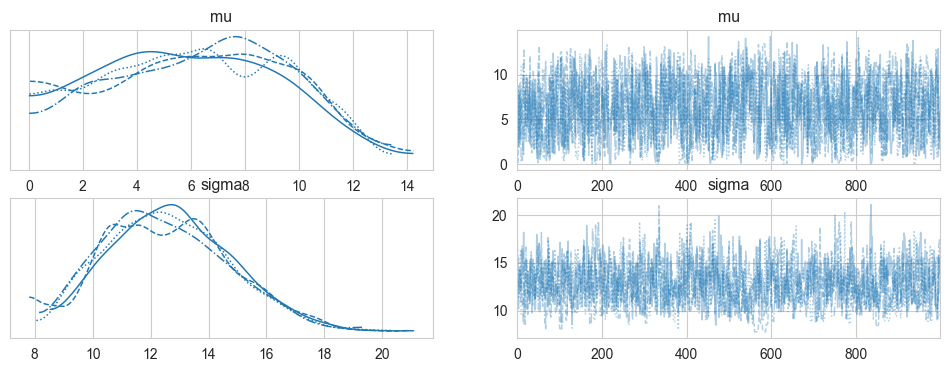

In [206]:
with pm.Model() as new_vehicle_model:
    # Priors for the parameters (need to remove reference to target_lsoa_data)
    mu = pm.Uniform('mu', lower=0, upper=np.max(target_lsoa_data))  # Prior for the mean
    sigma = pm.Uniform('sigma', lower=0, upper=50)  # Prior for the standard deviation

    # Likelihood (sampling distribution) of the observed data
    counts_observed = pm.TruncatedNormal('counts_observed', mu=mu, sigma=sigma, lower=0, observed=target_lsoa_data)

with new_vehicle_model:
    trace = pm.sample(draws=1000, tune=2000, random_seed=RANDOM_SEED, progressbar=True)

az.plot_trace(trace)

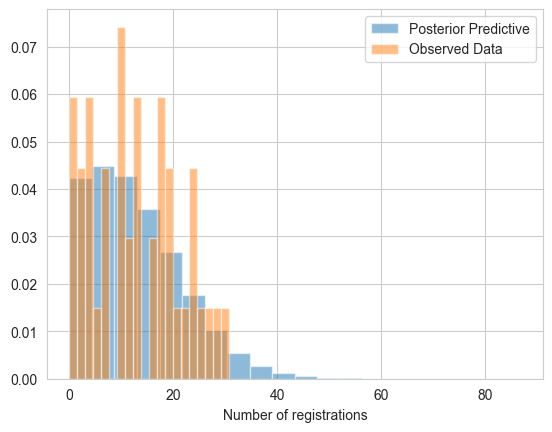

In [207]:
# Generate random samples from the posterior predictive distribution
with new_vehicle_model:
    posterior_predictive = pm.sample_posterior_predictive(trace)

# Plot the posterior predictive distribution
plt.hist(posterior_predictive.posterior_predictive.counts_observed.values.flatten(), bins=20, density=True, alpha=0.5, label='Posterior Predictive')
plt.hist(target_lsoa_data, bins=20, density=True, alpha=0.5, label='Observed Data')
plt.xlabel('Number of registrations')
plt.legend()
plt.show()

1. The forecast_dates are generated using the `calculate_date_range` function, which creates a range of numeric dates between `t0` (the present date obtained from `calculate_t_present(bev_lsoa_i)`) and `t1` (the horizon date) at a given sample rate of 4. These dates represent the quarters over which the forecast will be made.

2. `n_sim` is set to 1000, indicating the number of simulated forecasting trajectories. Each trajectory represents a different possible scenario or simulation of new vehicle registrations.

3. The `new_vehicles_random` array is created by randomly sampling from the `posterior_predictive` distribution, which contains simulated values for the number of new vehicle registrations (for all vehicle types) based on the Bayesian model. Each row of `new_vehicles_random` represents the number of registrations for a specific quarter, and each column represents one simulation trajectory.

4. Four DataFrames (`new_ev_lsoa_forecast`, `new_ice_lsoa_forecast`, `new_bev_lsoa_forecast`, and `new_phev_lsoa_forecast`) are initialized to hold the forecasted number of registrations for Electric Vehicles (EV), ICE vehicles, BEV, and PHEV, respectively, for different simulation trajectories and quarters.

5. The code then enters a loop that iterates through each simulation trajectory (from 0 to n_sim). For each simulation, it calculates the forecasted number of registrations for EVs, ICE vehicles, BEVs, and PHEVs for each quarter using the sales shares of these vehicle types (`ev_sales_share_lsoa`, `ice_sales_share_lsoa`, `bev_sales_share_lsoa`, and `phev_sales_share_lsoa`) and the randomly generated `new_vehicles_random` values.

6. The resulting DataFrames (`new_ev_lsoa_forecast`, `new_ice_lsoa_forecast`, `new_bev_lsoa_forecast`, and `new_phev_lsoa_forecast`) store the forecasted number of new registrations for each vehicle type and simulation trajectory over the specified quarters.

In [208]:
# Creates a range of numeric dates between t0 and t1 at a given sample rate
forecast_dates = calculate_date_range(t0=calculate_t_present(bev_lsoa_i), t1=horizon, sample_rate=4)

n_sim = 1000 # Number of simulated forecasting trajectories
new_vehicles_random = np.random.choice(posterior_predictive.posterior_predictive.counts_observed.values.flatten(), size=(n_sim, len(forecast_dates)))

new_ev_lsoa_forecast = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1))
new_ice_lsoa_forecast = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1))
new_bev_lsoa_forecast = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1))
new_phev_lsoa_forecast = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1))

# Simulate new registrations
for i in range(0, n_sim):
    new_ev_lsoa_forecast[i+1] = ev_sales_share_lsoa.loc[forecast_dates, target_lsoa].multiply(new_vehicles_random[i], axis='rows')
    new_ice_lsoa_forecast[i+1] = ice_sales_share_lsoa.loc[forecast_dates, target_lsoa].multiply(new_vehicles_random[i], axis='rows')
    new_bev_lsoa_forecast[i+1] = bev_sales_share_lsoa.loc[forecast_dates, target_lsoa].multiply(new_ev_lsoa_forecast[i+1], axis='rows')
    new_phev_lsoa_forecast[i+1] = phev_sales_share_lsoa.loc[forecast_dates, target_lsoa].multiply(new_ev_lsoa_forecast[i+1], axis='rows')

### Modelling Uncertainty in Vehicle Retirement Rate

#### *ICE*

Here's a step-by-step explanation of the code:

1. `veh1153` and `veh1103` are DataFrames containing historical data on new and total vehicle registrations each quarter, respectfully. These are filtered for a particular region (England in this case).

2. `.loc[:, 'ICE']` selects the 'ICE' column from both filtered DataFrames, which contains the number of ICEs registered for each date.

3. `.diff()` calculates the difference between consecutive values of the ICE stock (number of ICEs registered) in sequential quarters, giving the number of newly registered ICEs each quarter.

4. The number of new ICE registrations is then subtracted from the ICE stock in sequential quarters to estimate the number of retired ICEs in England each quarter.

5. `.divide(veh1103.loc[(veh1103['Geography'] == region), ['Date', 'ICE']].set_index('Date')['ICE'])` divides the number of retired ICEs by the total number of ICEs registered in each quarter to calculate the ICE retirement rate for England.

6. `.to_numpy()` converts the resulting Pandas Series into a NumPy array, which will contain the ICE retirement rates.

7. `ice_retirement_rates_np[ice_retirement_rates_np < 0] = np.nan` replaces any negative retirement rates (if the ICE stock decreases in a quarter) with NaN (Not a Number).

8. `ice_retirement_rates_np[~np.isnan(ice_retirement_rates_np)]` removes any NaN values from the NumPy array to obtain the final array of ICE retirement rates for England.

In [209]:
# Calculate the difference between the (English) ICE stock in sequential quarters using .diff()
# Subtract this from the number of new ICE registrations in the region (England) to estimate the number of retired ICEs in England each quarter
# Divide this by the number of total number of ICEs registered in each quarter to estimate an ICE retirement rate for England
# Convert this to a numpy array using to_numpy()

ice_retirement_rates_np = (
    veh1153.loc[(veh1153['Geography'] == region) & (veh1153['Date Interval'] == 'Quarterly')].set_index('Date').loc[:, 'ICE'] - 
    veh1103.loc[(veh1103['Geography'] == region)].set_index('Date').loc[:, 'ICE'].diff()
).divide(veh1103.loc[(veh1103['Geography'] == region), ['Date', 'ICE']].set_index('Date')['ICE']).to_numpy()

# Replace any negative retirements rates with np.nan
ice_retirement_rates_np[ice_retirement_rates_np < 0] = np.nan

# Remove any np.nan values
ice_retirement_rates_np = ice_retirement_rates_np[~np.isnan(ice_retirement_rates_np)]
ice_retirement_rates_np

array([0.00583681, 0.01524846, 0.00431182, 0.007433  , 0.01570797,
       0.01675996, 0.01381743, 0.02064203, 0.01791176, 0.02146763,
       0.01143643, 0.01607625, 0.02079969, 0.01613976, 0.0134881 ,
       0.01848381, 0.01803162, 0.01687316, 0.01287251, 0.01510106,
       0.02007641, 0.01789411, 0.00921135, 0.01748127, 0.02019893,
       0.01585596, 0.00949129, 0.01557079, 0.02228001, 0.01834959,
       0.01220538, 0.01900227, 0.0195418 , 0.01495232, 0.01630631,
       0.02035339, 0.01704531, 0.02029675, 0.01396113, 0.01826822,
       0.02013184, 0.02017083, 0.0131868 , 0.01654303, 0.01768678,
       0.01756927, 0.01290866, 0.01534086, 0.01808429, 0.01260252,
       0.01851678, 0.00962102, 0.0163665 , 0.01604864, 0.00594068,
       0.01448902, 0.01383047, 0.01009146, 0.00819288, 0.01128529,
       0.01261462])

<Axes: >

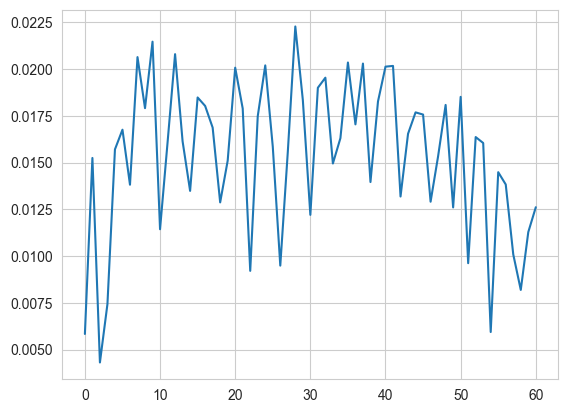

In [210]:
sns.lineplot(ice_retirement_rates_np)

Here's a step-by-step explanation of the code:

1. `mu = pm.Uniform('mu', lower=0, upper=0.5)`: This line defines a Uniform prior distribution for the parameter `mu`, which represents the mean of the ICE retirement rates. The prior is set to have a lower bound of 0 and an upper bound of 0.5, reflecting our belief about the possible range of retirement rate values.

2. `sigma = pm.Uniform('sigma', lower=0, upper=np.std(ice_retirement_rates_np) * 5)`: Similarly, this line defines a Uniform prior distribution for the parameter `sigma`, which represents the standard deviation of the ICE retirement rates. The prior is set to have a lower bound of 0 and an upper bound of five times the standard deviation of the observed ICE retirement rates. This expresses our uncertainty about the spread of the retirement rate data.

3. `counts_observed = pm.TruncatedNormal('retirement_rates', mu=mu, sigma=sigma, lower=0, observed=ice_retirement_rates_np)`: This line specifies the likelihood (sampling distribution) for the observed ICE retirement rates (`ice_retirement_rates_np`). It assumes that the retirement rates follow a Truncated Normal distribution with mean `mu`, standard deviation `sigma`, and lower bound of 0 (since retirement rates cannot be negative). The `observed` parameter is set to `ice_retirement_rates_np`, meaning that this observed data will be used to fit the model.

4. `pm.sample(...)`: This line performs the MCMC sampling to approximate the posterior distribution. It draws 1000 samples from the posterior, with 2000 tuning steps to adjust the sampling parameters. The `random_seed` is set to `RANDOM_SEED` for reproducibility, and `progressbar=True` enables the progress bar to monitor the sampling progress.

5. `az.plot_trace(retired_ice_trace)`: After sampling is complete, ArviZ is used to plot the trace of the sampled parameters. This visualization allows us to inspect the convergence and behavior of the MCMC chains and assess the model's performance.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

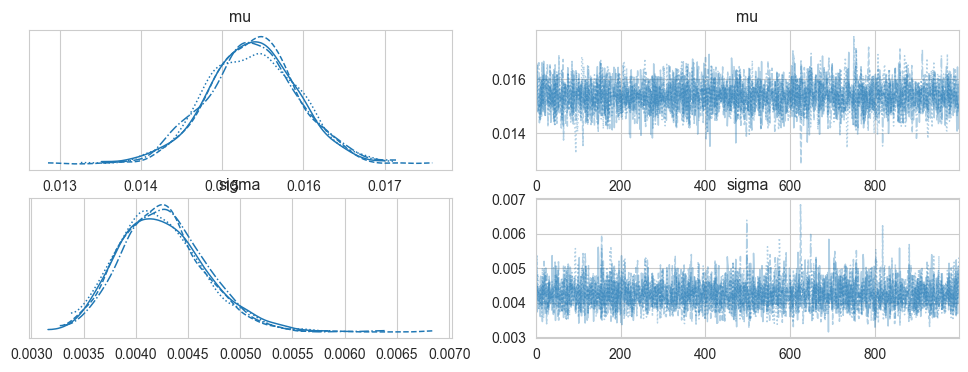

In [211]:
with pm.Model() as retired_ice_model:
    # Priors for the parameters (need to remove reference to target_lsoa_data)
    mu = pm.Uniform('mu', lower=0, upper=0.5)  # Prior for the mean
    sigma = pm.Uniform('sigma', lower=0, upper=np.std(ice_retirement_rates_np) * 5)  # Prior for the standard deviation

    # Likelihood (sampling distribution) of the observed data
    counts_observed = pm.TruncatedNormal('retirement_rates', mu=mu, sigma=sigma, lower=0, observed=ice_retirement_rates_np)
    
    retired_ice_trace = pm.sample(draws=1000, tune=2000, random_seed=RANDOM_SEED, progressbar=True)

az.plot_trace(retired_ice_trace)

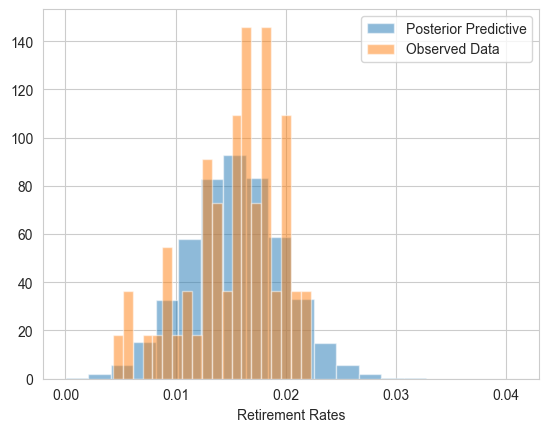

In [212]:
# Generate random samples from the posterior predictive distribution
with retired_ice_model:
    retired_ice_posterior_predictive = pm.sample_posterior_predictive(retired_ice_trace)

# Plot the posterior predictive distribution
plt.hist(retired_ice_posterior_predictive.posterior_predictive.retirement_rates.values.flatten(), bins=20, density=True, alpha=0.5, label='Posterior Predictive')
plt.hist(ice_retirement_rates_np, bins=20, density=True, alpha=0.5, label='Observed Data')
plt.xlabel('Retirement Rates')
plt.legend()
plt.show()

#### *BEV*

Due to the fact that BEVs and PHEVs are relatively new to the vehicle market, using historical data is not a reliable way of estimating their retirement rate.

1. `mu = pm.Normal('mu', mu=bev/phev_lifetime, sigma=3)`: This line defines a Normal prior distribution for the parameter `mu`, which represents the mean lifetime of BEVs and PHEVs. The priors are centered around `bev_lifetime` and `phev_lifetime`, indicating our initial belief about the typical BEV and PHEV lifetime, and has a standard deviation of 3, expressing uncertainty about the actual lifetime values.

2. `sigma = pm.Exponential('sigma', lam=2)`: Similarly, this line defines an Exponential prior distribution for the parameter `sigma`, representing the standard deviation of the BEV and PHEV lifetime. The `lam` parameter sets the rate (inverse scale) of the Exponential distribution, influencing the spread of the lifetime values.

3. `vehicle_lifetime = pm.TruncatedNormal('vehicle_lifetime', mu=mu, sigma=sigma, lower=0)`: This line specifies the likelihood (sampling distribution) for the BEV and PHEV lifetime. It assumes that the lifetime of BEVs and PHEVs follow a Truncated Normal distribution with mean `mu`, standard deviation `sigma`, and lower bound of 0 (since the lifetime cannot be negative).

4. `retirement_rate = pm.Deterministic('retirement_rate', 1/(4*vehicle_lifetime))`: This line calculates the retirement rate of BEVs and PHEVs as a deterministic function of their lifetime. The retirement rate is assumed to be the inverse of (4 times) the BEV lifetime, which represents the proportion of BEVs and PHEVs retired each quarter.

5. `pm.sample_prior_predictive(samples=1000, random_seed=RANDOM_SEED)`: This line samples 1000 data points from the prior predictive distribution. It simulates possible values of the BEV and PHEV lifetimes and retirement rate according to the specified priors.

6. Histograms are then plotted to visualize the prior predictive distribution for both the lifetime and the retirement rate for BEVs and PHEVs.

7. The first plot shows the prior predictive distribution for lifetime. The histogram represents the density of different lifetime values, allowing us to understand the prior uncertainty about lifetimes.

8. The second plot shows the prior predictive distribution for the retirement rate. The histogram represents the density of different retirement rate values, indicating our prior uncertainty about the proportion of BEVs and PHEVs retired each year.

Sampling: [mu, sigma, vehicle_lifetime]


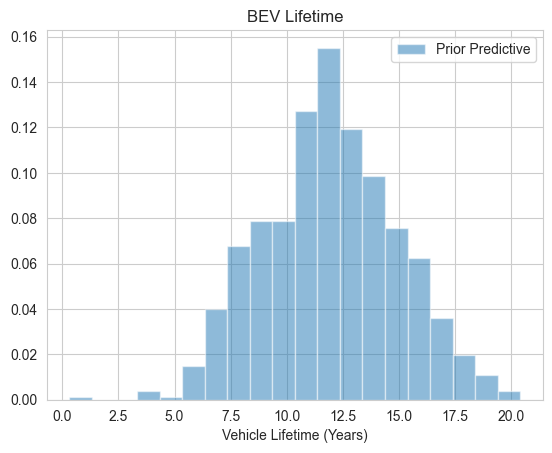

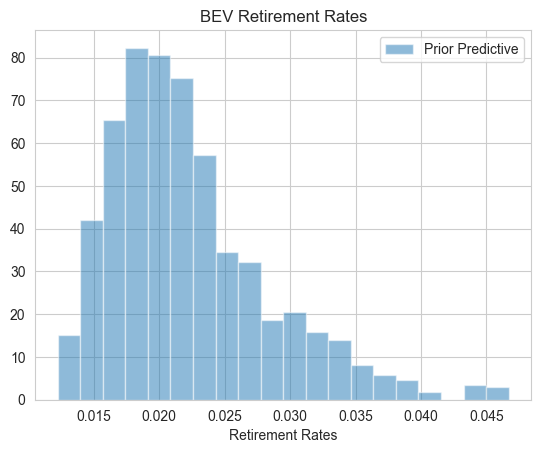

In [49]:
with pm.Model() as retired_bev_model:
    # Priors for the parameters (need to remove reference to target_lsoa_data)
    mu = pm.Normal('mu', mu=bev_lifetime, sigma=3)  # Prior for the mean
    sigma = pm.Exponential('sigma', lam=2)  # Prior for the standard deviation

    # Likelihood (sampling distribution) of the observed data
    vehicle_lifetime = pm.TruncatedNormal('vehicle_lifetime', mu=mu, sigma=sigma, lower=0)
    retirement_rate = pm.Deterministic('retirement_rate', 1/(4*vehicle_lifetime))

with retired_bev_model:
    retired_bev_prior_predictive = pm.sample_prior_predictive(samples=1000, random_seed=RANDOM_SEED)

# Plot the prior predictive distribution for vehicle lifetime
plt.hist(
    retired_bev_prior_predictive.prior.vehicle_lifetime.values.flatten(), 
    bins=20, 
    density=True, 
    alpha=0.5, 
    label='Prior Predictive'
)
# plt.xlim(0, 0.5)
plt.xlabel('Vehicle Lifetime (Years)')
plt.legend()
plt.title('BEV Lifetime')
plt.show()

# Plot the prior predictive distribution for retirement rate
plt.hist(
    retired_bev_prior_predictive.prior.retirement_rate.values.flatten()[retired_bev_prior_predictive.prior.retirement_rate.values.flatten()<0.05], 
    bins=20, 
    density=True, 
    alpha=0.5, 
    label='Prior Predictive'
)
# plt.xlim(0, 0.5)
plt.xlabel('Retirement Rates')
plt.legend()
plt.title('BEV Retirement Rates')
plt.show()

#### *PHEV*

Sampling: [mu, sigma, vehicle_lifetime]


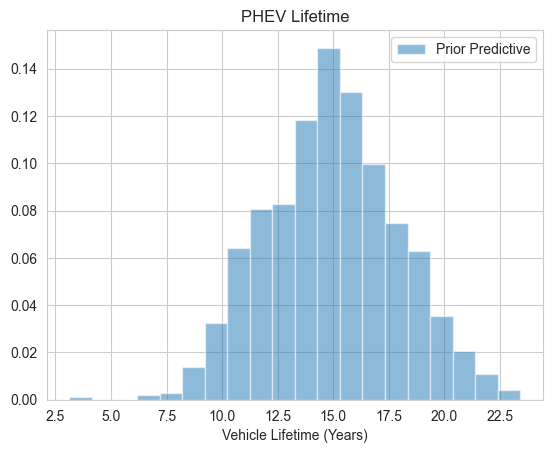

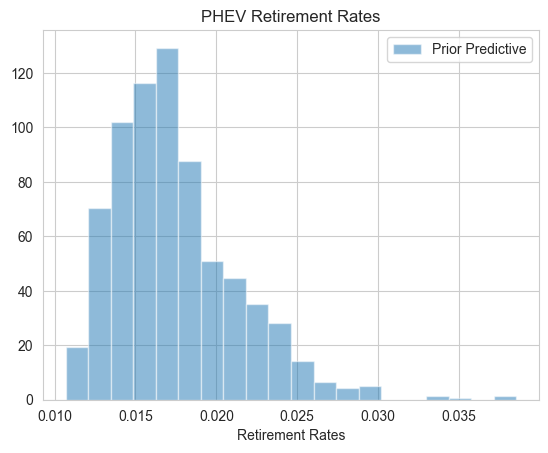

In [48]:
with pm.Model() as retired_phev_model:
    # Priors for the parameters (need to remove reference to target_lsoa_data)
    mu = pm.Normal('mu', mu=phev_lifetime, sigma=3)  # Prior for the mean
    sigma = pm.Exponential('sigma', lam=2)  # Prior for the standard deviation

    # Likelihood (sampling distribution) of the observed data
    vehicle_lifetime = pm.TruncatedNormal('vehicle_lifetime', mu=mu, sigma=sigma, lower=0)
    retirement_rate = pm.Deterministic('retirement_rate', 1/(4*vehicle_lifetime))

with retired_phev_model:
    retired_phev_prior_predictive = pm.sample_prior_predictive(samples=1000, random_seed=RANDOM_SEED)

# Plot the prior predictive distribution for vehicle lifetime
plt.hist(
    retired_phev_prior_predictive.prior.vehicle_lifetime.values.flatten(), 
    bins=20, 
    density=True, 
    alpha=0.5, 
    label='Prior Predictive'
)
# plt.xlim(0, 0.5)
plt.xlabel('Vehicle Lifetime (Years)')
plt.legend()
plt.title('PHEV Lifetime')
plt.show()

# Plot the prior predictive distribution for retirement rates
plt.hist(
    retired_phev_prior_predictive.prior.retirement_rate.values.flatten()[retired_phev_prior_predictive.prior.retirement_rate.values.flatten()<0.05], 
    bins=20, 
    density=True, 
    alpha=0.5, 
    label='Prior Predictive'
)
# plt.xlim(0, 0.5)
plt.xlabel('Retirement Rates')
plt.legend()
plt.title('PHEV Retirement Rates')
plt.show()

1. Three DataFrames (`bev_forecast_lsoa`, `phev_forecast_lsoa`, and `ice_forecast_lsoa`) are created to hold the forecasted data for BEVs, PHEVs, and ICEs registrations in different LSOAs.

2. The most recent entries in the interpolated registration data for the three vehicle types (`bev_lsoa_i`, `phev_lsoa_i`, and `ice_lsoa_i`) are used to populate the first row of the forecast DataFrames. This data represents the starting registrations for the forecast period.

3. Random retirement rates are sampled from posterior/prior predictive distributions for ICEs, BEVs and PHEVs. These rates are then used to simulate the retirement of vehicles from the existing registered fleet during the forecast period. The sampled rates represent the probability of vehicles being retired each quarter.

4. The forecasting process iterates over each forecasted date (quarter). For each date, the forecasted number of new registrations for BEV, PHEV, and ICE (`new_bev_lsoa_forecast`, `new_phev_lsoa_forecast`, and `new_ice_lsoa_forecast`) is added to the previous quarter's forecasted registrations, and the number of retired vehicles is subtracted based on the sampled retirement rates. This results in new forecasted registrations for each vehicle type for the given LSOA and quarter.

5. The resulting forecast DataFrames (`bev_forecast_lsoa`, `phev_forecast_lsoa`, and `ice_forecast_lsoa`) are then rounded to whole numbers, as vehicle registrations are typically whole numbers.

6. Finally, the forecasted registration data for each vehicle type and LSOA are plotted separately to visualize the simulation-based forecasts over time.

<Axes: >

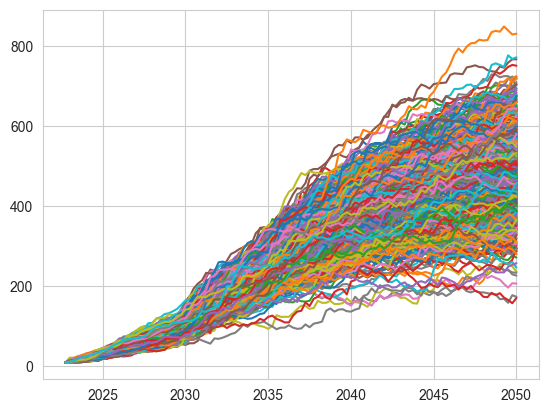

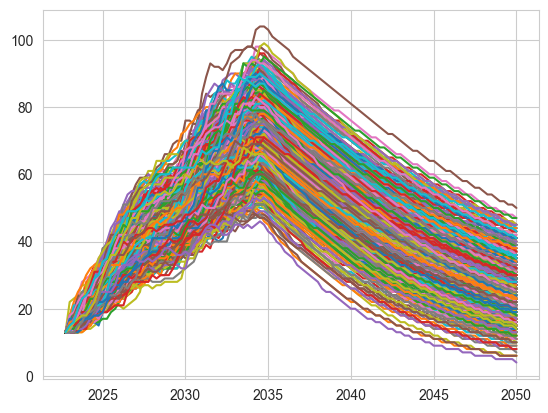

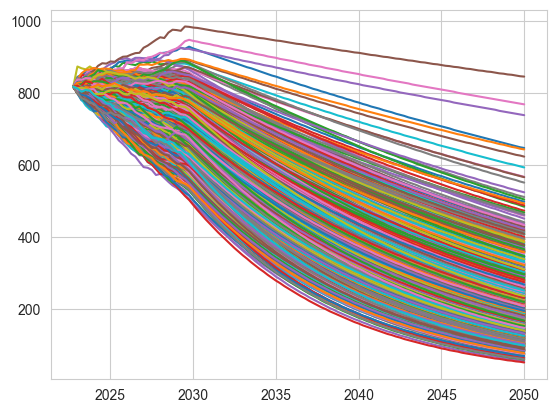

In [213]:
# Create dataframes that contain a column for each simulation and a row for each forecasted date
bev_forecast_lsoa = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1), dtype=float)
phev_forecast_lsoa = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1), dtype=float)
ice_forecast_lsoa = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1), dtype=float)

# Populate forecast with inital starting registrations
bev_forecast_lsoa.iloc[0] = bev_lsoa_i[target_lsoa].iloc[-1]
phev_forecast_lsoa.iloc[0] = phev_lsoa_i[target_lsoa].iloc[-1]
ice_forecast_lsoa.iloc[0] = ice_lsoa_i[target_lsoa].iloc[-1]

# Randomly sample retirement rates from posterior/prior predictive distributions
ice_retirement_rates_random = np.random.choice(retired_ice_posterior_predictive.posterior_predictive.retirement_rates.values.flatten(), size=(n_sim))
bev_retirement_rates_random = np.random.choice(retired_bev_prior_predictive.prior.retirement_rate.values.flatten(), size=(n_sim))
phev_retirement_rates_random = np.random.choice(retired_phev_prior_predictive.prior.retirement_rate.values.flatten(), size=(n_sim))

# Making the forecasts by adding new registrations and removing retired vehicles
for i in range(1, len(forecast_dates)):
    bev_forecast_lsoa.loc[forecast_dates[i]] = bev_forecast_lsoa.loc[forecast_dates[i-1]] + new_bev_lsoa_forecast.loc[forecast_dates[i]] - (bev_retirement_rates_random * bev_forecast_lsoa.loc[forecast_dates[i-1]])
    phev_forecast_lsoa.loc[forecast_dates[i]] = phev_forecast_lsoa.loc[forecast_dates[i-1]] + new_phev_lsoa_forecast.loc[forecast_dates[i]] - (phev_retirement_rates_random * phev_forecast_lsoa.loc[forecast_dates[i-1]])
    ice_forecast_lsoa.loc[forecast_dates[i]] = ice_forecast_lsoa.loc[forecast_dates[i-1]] + new_ice_lsoa_forecast.loc[forecast_dates[i]] - (ice_retirement_rates_random * ice_forecast_lsoa.loc[forecast_dates[i-1]])

bev_forecast_lsoa = round(bev_forecast_lsoa)
phev_forecast_lsoa = round(phev_forecast_lsoa)
ice_forecast_lsoa = round(ice_forecast_lsoa)

bev_forecast_lsoa.plot(legend=False)
phev_forecast_lsoa.plot(legend=False)
ice_forecast_lsoa.plot(legend=False)

### Plotting Percentile Ranges

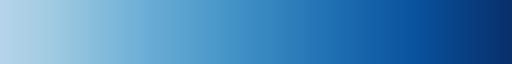

In [217]:
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.colormaps['Blues']
new_cmap = truncate_colormap(cmap, 0.3, 1)
new_cmap

In [218]:
NUM_COLORS = 20
cm = plt.get_cmap('Paired')
colors = [new_cmap(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

In [321]:
def plot_probabilistic_vehicle_forecasts_lsoa(df, historical_df, vehicle_type):
    
    fig, ax = plt.subplots(figsize=(12,6))

    ax.fill_between(
        x=df.index.values, 
        y1=df.quantile(0.01, axis=1).values, 
        y2=df.quantile(0.99, axis=1).values, 
        color=colors[19],
        alpha=0.1,
        label='1st to 99th Percentile'
    )

    ax.fill_between(
        x=df.index.values, 
        y1=df.quantile(0.05, axis=1).values, 
        y2=df.quantile(0.95, axis=1).values, 
        color=colors[19],
        alpha=0.2,
        label='5th to 95th Percentile'
    )

    ax.fill_between(
        x=df.index.values, 
        y1=df.quantile(0.1, axis=1).values, 
        y2=df.quantile(0.9, axis=1).values, 
        color=colors[19],
        alpha=0.4,
        label='10th to 90th Percentile'
    )

    ax.fill_between(
        x=df.index.values, 
        y1=df.quantile(0.25, axis=1).values, 
        y2=df.quantile(0.75, axis=1).values, 
        color=colors[19],
        alpha=0.6,
        label='Interquartile Range'
    )

    ax.plot(
        df.index.values, 
        df.quantile(0.5, axis=1).values, 
        linewidth=2, 
        c='black', 
        label='Median'
    )

    ax.plot(
        convert_dates_to_numeric(historical_df.dropna()),
        historical_df[target_lsoa].dropna().values,
        linewidth=2,
        c='green',
        label='Historical Data'
    )

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles, 
        labels, 
        # bbox_to_anchor=(1, 0.9), 
        title='Percentile', 
        title_fontsize=16, 
        fontsize=10
    )
    ax.set_title('Forecasted number of {}s for LSOA: {}'.format(vehicle_type, target_lsoa))
    ax.set_ylabel('Number of Registered Vehicles', fontsize=12)
    ax.set_xlabel('Time (Years)', fontsize=12)
    # ax.set_xlim(2022, horizon)
    plt.show()

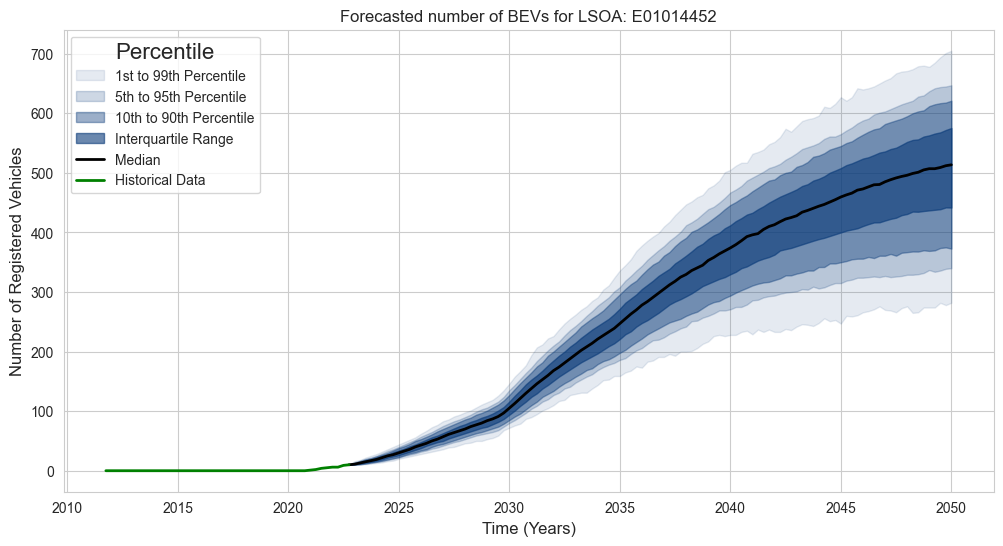

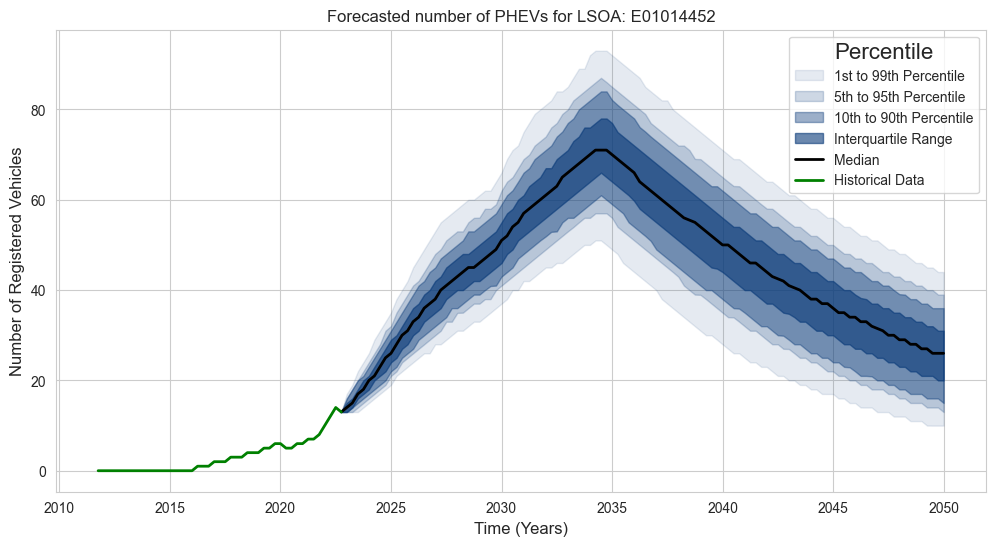

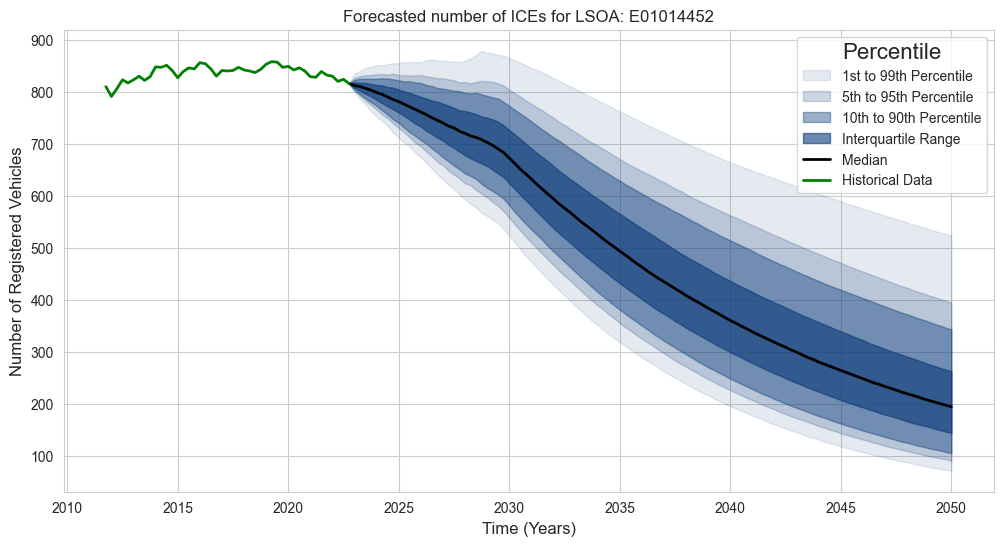

In [220]:
plot_probabilistic_vehicle_forecasts_lsoa(bev_forecast_lsoa, bev_lsoa_i, 'BEV')
plot_probabilistic_vehicle_forecasts_lsoa(phev_forecast_lsoa, phev_lsoa_i, 'PHEV')
plot_probabilistic_vehicle_forecasts_lsoa(ice_forecast_lsoa, ice_lsoa_i, 'ICE')

# Mapping EVs to Distribution Substations (DS)

### DS Customer Data
The important sets of information in this dataset are: 

- The number of customers (assumed to be number of households)

- The location of the distribution substation

- The max day demand of the distribution substation

In [51]:
ds = (
    pd.read_csv('../../data/network_data/distribution_substations.csv')
    .drop(
        columns = [
            'Transformer Headroom', 'LCT Count Total', 'Energy Storage', 'Heat Pumps', 
            'EV Chargers', 'Total LCT Capacity', 'Total Generation Capacity', 'Solar', 
            'Wind', 'Bio Fuels', 'Water Generation', 'Waste Generation',
            'Storage Generation', 'Fossil Fuels', 'Other Generation']
    )
    .replace('Hidden', np.nan)
    .astype({'Customers':'float64', 'Substation Number':'Int64'})
    .astype({'Substation Number': str})
)
ds.head()

/var/folders/3p/gfh9bx_x6g538359fqt4lgtm0000gn/T/ipykernel_97697/1009921689.py:2: DtypeWarning: Columns (19,20,21,22,23,24,25,26,27,28,29,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv('../../data/network_data/distribution_substations.csv')


index License Area  Grid Supply Point Number Grid Supply Point Name  \
0      0   South West                    306004          Abham  S.G.P.   
1      1   South West                    306004          Abham  S.G.P.   
2      2   South West                    306004          Abham  S.G.P.   
3      4   South West                    306004          Abham  S.G.P.   
4      5   South West                    406003       Landulph  S.G.P.   

   Bulk Supply Point Number Bulk Supply Point Name     Primary Name  \
0                    330006           Plympton Bsp    Linketty Lane   
1                    330003           Plymouth Bsp  Plymstock South   
2                    330003           Plymouth Bsp  Plymstock South   
3                    330006           Plympton Bsp    Linketty Lane   
4                    330001         Ernesettle Bsp         Southway   

   Primary Number    HV Feeder Substation Type       Substation Name  \
0          330029  330029/0016        Grd Mtd     Burniston Close 47   
1          330037  330037/0017        Grd Mtd          Furland Close   
2          330037  330037/0018        Grd Mtd           Staddon Park   
3          330029  330029/0016        Grd Mtd        St Maurice Road   
4          330023  330023/0046        Grd Mtd   Birch Valley Plastic   

  Substation Number  Grid Reference  LONGITUDE   LATITUDE  Day Max Demand  \
0            331299  SX553570552680  -4.035800  50.379400           189.0   
1            332445  SX504350522380  -4.103733  50.350925            88.0   
2            331216  SX513550525160  -4.090900  50.353700           184.0   
3            331196  SX548280554220  -4.043300  50.380700           286.0   
4            333252  SX513960603110  -4.093400  50.423700           746.0   

   Night Max Demand  Substation Rating  Customers  
0              78.0              500.0      115.0  
1              46.0             1000.0       59.0  
2             106.0              500.0      149.0  
3             121.0              500.0      178.0  
4             453.0             1000.0       27.0

#### DS Geospatial Data
This dataset is useful as it contains the approximate polygons for the boundaries of the distribution substation areas. Here, it is merged with the DS customer data. 

In [52]:
ds_geo = (
    gpd.read_file('../../data/network_data/dist_swest_march2023.gpkg')
    .rename(columns={'NR':'Substation Number'})
    .dissolve('Substation Number').reset_index()
    .merge(ds, how='left', on ='Substation Number')
    .rename(columns={'Substation Name':'Name'})
    .fillna(value={'Discount':'Unknown'}) # For the "key_on" part of the choropleth map
    .to_crs('EPSG:4326')
)

ds_geo['Location'] = gpd.GeoSeries(gpd.points_from_xy(ds_geo.LONGITUDE, ds_geo.LATITUDE, crs="EPSG:4326"))

ds_geo.head()

Substation Number                                           geometry   NRID  \
0            110001  MULTIPOLYGON (((-2.58570 51.47167, -2.58578 51...  33447   
1            110002  MULTIPOLYGON (((-2.59002 51.47053, -2.59028 51...  33449   
2            110003  POLYGON ((-2.59156 51.47416, -2.59154 51.47425...  33451   
3            110003  POLYGON ((-2.59156 51.47416, -2.59154 51.47425...  33451   
4            110004  MULTIPOLYGON (((-2.58898 51.47610, -2.58895 51...  33453   

   NR_TYPE_ID                NAME  PRIM_NRID     PRIM_NRID_NAME  BSP_NRID  \
0          19  Chesterfield Rd Id      15039  St Pauls Bsp 11kv       104   
1          19   Effingham Road Id      15039  St Pauls Bsp 11kv       104   
2          19       Somerville Rd      15039  St Pauls Bsp 11kv       104   
3          19       Somerville Rd      15039  St Pauls Bsp 11kv       104   
4          19         Kent Road P      15039  St Pauls Bsp 11kv       104   

        BSP_NRID_NAME  GSP_NRID  ...    HV Feeder  Substation Type  \
0  St Pauls Bsp 132kv       130  ...  110804/0055         Grd Mtd    
1  St Pauls Bsp 132kv       130  ...  110804/0055         Grd Mtd    
2  St Pauls Bsp 132kv       130  ...  110804/0055         Grd Mtd    
3  St Pauls Bsp 132kv       130  ...  110804/0055         Grd Mtd    
4  St Pauls Bsp 132kv       130  ...  110804/0055         Grd Mtd    

                 Name  Grid Reference LONGITUDE  LATITUDE Day Max Demand  \
0  Chesterfield Rd Id  ST596270749730   -2.5827   51.4722          568.0   
1   Effingham Road Id  ST591950749860   -2.5889   51.4723          458.0   
2       Somerville Rd  ST590740753250   -2.5907   51.4753           10.0   
3       Somerville Rd  ST590740753250   -2.5907   51.4753            0.0   
4         Kent Road P  ST593560755280   -2.5867   51.4772          607.0   

  Night Max Demand  Substation Rating Customers  
0            343.0              750.0     367.0  
1            275.0              750.0     331.0  
2              4.0              250.0     254.0  
3              0.0              500.0       NaN  
4            320.0              750.0     276.0  

[5 rows x 29 columns]

### Filter DS by LAD

<Axes: >

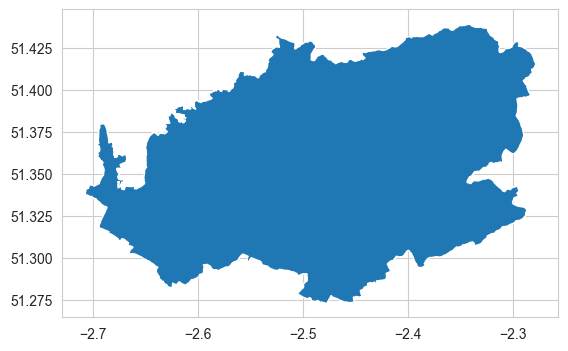

In [55]:
LAD_geo = ox.geocoder.geocode_to_gdf(LAD, which_result=1)
LAD_geo.plot()

In [469]:
ds_LAD = ds_geo.loc[ds_geo.Location.within(LAD_geo.geometry.values[0])]
ds_LAD.head()

Substation Number                                           geometry  \
37             110055  POLYGON ((-2.46167 51.39973, -2.46174 51.39976...   
39             110060  POLYGON ((-2.49497 51.40702, -2.49581 51.40727...   
44             110066  POLYGON ((-2.49769 51.40349, -2.49779 51.40351...   
107            110165  POLYGON ((-2.51360 51.41669, -2.51393 51.41716...   
123            110182  POLYGON ((-2.46675 51.40341, -2.46675 51.40341...   

      NRID  NR_TYPE_ID               NAME  PRIM_NRID PRIM_NRID_NAME  BSP_NRID  \
37   33528          19        Saltford Od      15042  Keynsham East       119   
39   33532          19  Keelings       Ss      15042  Keynsham East       119   
44   33542          19   Burnett Rd     K      15042  Keynsham East       119   
107  33683          19  Stockwood Vale Od      15049  Keynsham West    128239   
123  33715          19   Grange Road    K      15042  Keynsham East       119   

          BSP_NRID_NAME  GSP_NRID  ... Substation Type  \
37   Radstock Bsp 132kv    136677  ...        Grd Mtd    
39   Radstock Bsp 132kv    136677  ...        Grd Mtd    
44   Radstock Bsp 132kv    136677  ...        Grd Mtd    
107    Feeder Road 33kv       130  ...        Grd Mtd    
123  Radstock Bsp 132kv    136677  ...        Grd Mtd    

                         Name  Grid Reference  LONGITUDE   LATITUDE  \
37                Saltford Od  ST682140670940   -2.45840  51.401900   
39          Keelings       Ss  ST658270679910   -2.49280  51.409800   
44           Burnett Rd     K  ST658460673840   -2.49242  51.404389   
107         Stockwood Vale Od  ST644800689440   -2.51220  51.418300   
123  Grange Road  K  Saltford  ST677120673570   -2.46560  51.404300   

     Day Max Demand Night Max Demand Substation Rating  Customers  \
37            339.0            228.0             500.0      129.0   
39            204.0             90.0             315.0      114.0   
44            157.0             70.0             300.0       95.0   
107           102.0             49.0             500.0       47.0   
123           104.0             50.0             315.0       54.0   

                      Location  
37   POINT (-2.45840 51.40190)  
39   POINT (-2.49280 51.40980)  
44   POINT (-2.49242 51.40439)  
107  POINT (-2.51220 51.41830)  
123  POINT (-2.46560 51.40430)  

[5 rows x 30 columns]

Text(0.5, 1.0, 'Distribution Substations (Estimated Polygons) in BANES')

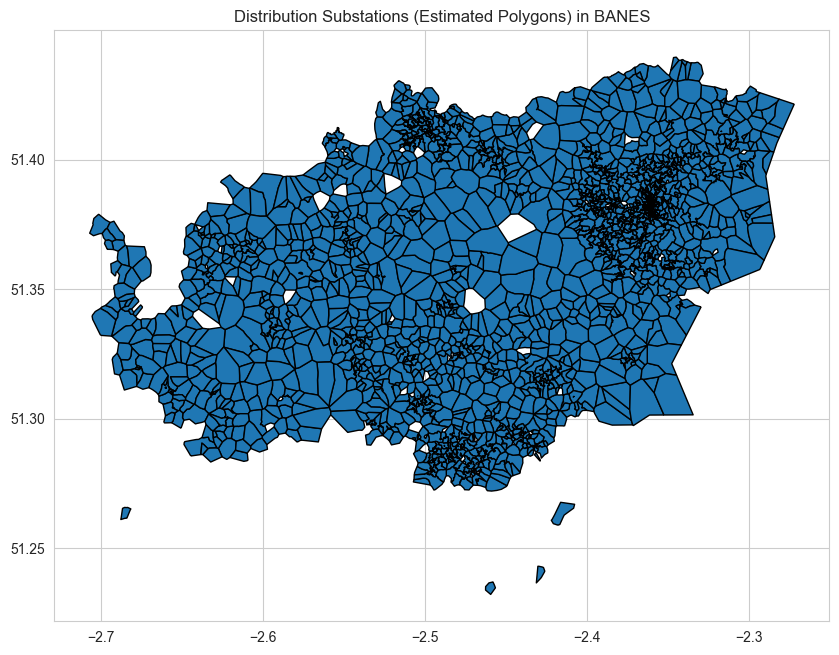

In [470]:
ds_LAD.plot(edgecolor='k', figsize=(10,10))
plt.title('Distribution Substations (Estimated Polygons) in BANES')

### Filter LSOAs based on target LAD

- This is simply because I need to convert the ESPG from 27700 to 4326. 

- This takes a ridiculously long time when try to convert all of the geometries of the LSOAs in the UK. 

- Therefore, to speed things up, I need to filter the LSOAs first and then apply the coordinate transformation

In [57]:
lsoa_geo = (
    gpd.read_file('../../data/spatial_data/lsoa_data/Lower_Layer_Super_Output_Areas__December_2011__Boundaries_Full_Clipped__BFC__EW_V3.shp')
    .merge(lsoa_lookup.loc[:, ['LSOA11CD', 'LAD22NM']], on = 'LSOA11CD', how='outer')
    .set_index('LSOA11CD')
) 
lsoa_geo.head()

OBJECTID                   LSOA11NM   BNG_E   BNG_N     LONG_  \
LSOA11CD                                                                   
E01000001         1        City of London 001A  532123  181632 -0.097140   
E01000002         2        City of London 001B  532480  181715 -0.091970   
E01000003         3        City of London 001C  532239  182033 -0.095320   
E01000005         4        City of London 001E  533581  181283 -0.076270   
E01000006         5  Barking and Dagenham 016A  544994  184274  0.089317   

               LAT   Shape_Leng     Shape__Are   Shape__Len  \
LSOA11CD                                                      
E01000001  51.5182  2635.767993  129865.314354  2635.767993   
E01000002  51.5188  2707.881853  228419.634727  2707.881853   
E01000003  51.5217  1224.638192   59054.351929  1224.638192   
E01000005  51.5147  2275.805348  189577.710655  2275.805348   
E01000006  51.5387  1966.092607  146536.995750  1966.092607   

                                                    geometry  \
LSOA11CD                                                       
E01000001  POLYGON ((532151.537 181867.433, 532152.500 18...   
E01000002  POLYGON ((532634.497 181926.016, 532632.048 18...   
E01000003  POLYGON ((532153.703 182165.155, 532158.250 18...   
E01000005  POLYGON ((533619.062 181402.364, 533639.868 18...   
E01000006  POLYGON ((545126.852 184310.838, 545145.213 18...   

                        LAD22NM  
LSOA11CD                         
E01000001        City of London  
E01000002        City of London  
E01000003        City of London  
E01000005        City of London  
E01000006  Barking and Dagenham

In [58]:
lsoa_LAD = lsoa_geo.loc[lambda x: x['LAD22NM'] == LAD].to_crs('EPSG:4326') # Filter for LA and change CRS
lsoa_LAD.head()

OBJECTID                           LSOA11NM   BNG_E   BNG_N  \
LSOA11CD                                                                 
E01014370     13973  Bath and North East Somerset 007A  375084  164994   
E01014371     13974  Bath and North East Somerset 007B  375328  164841   
E01014372     13975  Bath and North East Somerset 007C  374832  165378   
E01014373     13976  Bath and North East Somerset 010A  377791  167691   
E01014374     13977  Bath and North East Somerset 010B  378059  166769   

             LONG_      LAT    Shape_Leng    Shape__Are    Shape__Len  \
LSOA11CD                                                                
E01014370 -2.35941  51.3834   4168.323516  3.770303e+05   4168.323516   
E01014371 -2.35590  51.3821   4146.079795  4.094906e+05   4146.079795   
E01014372 -2.36306  51.3869   2870.144109  1.668015e+05   2870.144109   
E01014373 -2.32068  51.4078   6720.118267  1.059979e+06   6720.118267   
E01014374 -2.31677  51.3995  19927.251976  5.002127e+06  19927.251976   

                                                    geometry  \
LSOA11CD                                                       
E01014370  POLYGON ((-2.35647 51.38920, -2.35618 51.38913...   
E01014371  POLYGON ((-2.35166 51.38534, -2.35158 51.38530...   
E01014372  POLYGON ((-2.35597 51.38950, -2.35587 51.38942...   
E01014373  POLYGON ((-2.32115 51.41364, -2.32114 51.41364...   
E01014374  POLYGON ((-2.30592 51.40806, -2.30591 51.40806...   

                                LAD22NM  
LSOA11CD                                 
E01014370  Bath and North East Somerset  
E01014371  Bath and North East Somerset  
E01014372  Bath and North East Somerset  
E01014373  Bath and North East Somerset  
E01014374  Bath and North East Somerset

Text(0.5, 1.0, 'Lower Super Output Areas (LSOAs) in BANES')

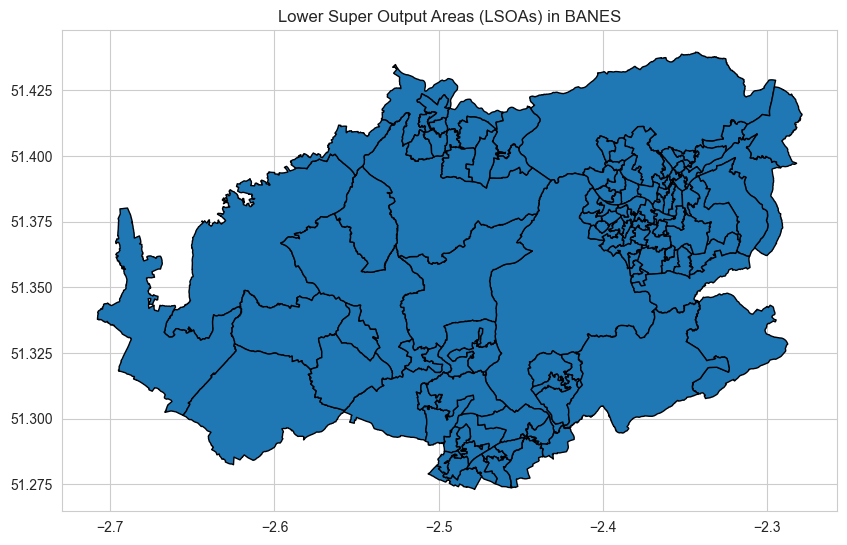

In [472]:
lsoa_LAD.plot(edgecolor='k', figsize=(10,10))
plt.title('Lower Super Output Areas (LSOAs) in BANES')

### Identify Target DS

In [365]:
ds_LAD.sort_values(ascending=False, by='Customers').head(5)

Substation Number                                           geometry  \
3398            160091  POLYGON ((-2.37278 51.38952, -2.37253 51.39025...   
3383            160068  POLYGON ((-2.34873 51.39390, -2.34873 51.39391...   
3359            160037  POLYGON ((-2.36301 51.38734, -2.36302 51.38738...   
3385            160070  POLYGON ((-2.39636 51.37256, -2.39636 51.37258...   
3360            160038  MULTIPOLYGON (((-2.35334 51.38431, -2.35337 51...   

       NRID  NR_TYPE_ID               NAME  PRIM_NRID       PRIM_NRID_NAME  \
3398  39408          19  Park Street Local      15062          Park Street   
3383  39373          19        St Saviours      15065           Batheaston   
3359  39322          19          Hedgemead      15062          Park Street   
3385  39378          19           Innox Rd      15066              Twerton   
3360  39324          19           Holburne     302497  Dorchester St - New   

      BSP_NRID         BSP_NRID_NAME  GSP_NRID  ... Substation Type  \
3398        94  Bath (Dolemeads) 132       131  ...        Grd Mtd    
3383        94  Bath (Dolemeads) 132       131  ...        Grd Mtd    
3359        94  Bath (Dolemeads) 132       131  ...        Grd Mtd    
3385        94  Bath (Dolemeads) 132       131  ...        Grd Mtd    
3360        94  Bath (Dolemeads) 132       131  ...        Grd Mtd    

                   Name  Grid Reference  LONGITUDE LATITUDE  Day Max Demand  \
3398  Park Street Local  ST745000657340    -2.3679  51.3900           677.0   
3383        St Saviours  ST760600663620    -2.3455  51.3957           718.0   
3359          Hedgemead  ST749400656090    -2.3616  51.3889           678.0   
3385           Innox Rd  ST728940642060    -2.3909  51.3762           692.0   
3360           Holburne  ST757240652210    -2.3503  51.3855           591.0   

     Night Max Demand Substation Rating  Customers                   Location  
3398            642.0             750.0      555.0  POINT (-2.36790 51.39000)  
3383            515.0             800.0      527.0  POINT (-2.34550 51.39570)  
3359            513.0            1000.0      511.0  POINT (-2.36160 51.38890)  
3385            362.0             800.0      485.0  POINT (-2.39090 51.37620)  
3360            648.0            1000.0      442.0  POINT (-2.35030 51.38550)  

[5 rows x 30 columns]

In [437]:
target_ds = '160038' # '110055'

### Find Parent LSOA(s)

In [461]:
intersections = lsoa_LAD.geometry.intersection(ds_LAD[ds_LAD['Substation Number'] == target_ds].geometry.values[0])
pip_mask = ~intersections.is_empty
parent_lsoa = lsoa_LAD[pip_mask].index.values
parent_lsoa

array(['E01014371', 'E01014381', 'E01014468'], dtype=object)

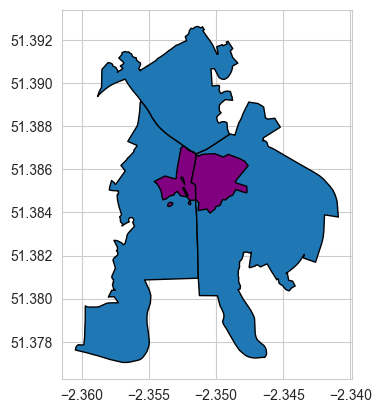

In [440]:
fig, ax = plt.subplots()
lsoa_LAD[pip_mask].plot(ax=ax, edgecolor='k')
intersections[pip_mask].plot(ax=ax, color='purple', edgecolor='k')
plt.show()

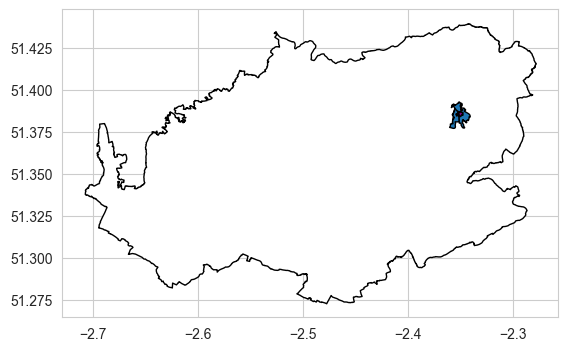

In [441]:
fig, ax = plt.subplots()
LAD_geo.plot(ax=ax, color='white', edgecolor='k')
lsoa_LAD[pip_mask].plot(ax=ax, edgecolor='k')
intersections[pip_mask].plot(ax=ax, color='purple', edgecolor='k')
plt.show()

In [442]:
ds_intersection_relative_area = intersections[pip_mask].area/ds_LAD[ds_LAD['Substation Number'] == target_ds].iloc[0].geometry.area
ds_intersection_relative_area

/var/folders/3p/gfh9bx_x6g538359fqt4lgtm0000gn/T/ipykernel_97697/1227420334.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ds_intersection_relative_area = intersections[pip_mask].area/ds_LAD[ds_LAD['Substation Number'] == target_ds].iloc[0].geometry.area


LSOA11CD
E01014371    0.335098
E01014381    0.664811
E01014468    0.000091
dtype: float64

### LSOA Number of Households

In [443]:
house_lsoa = (
    pd.read_csv('../../data/demographic_data/census_2021/LSOA_households.csv')
    .rename(columns={'Lower layer Super Output Areas Code':'LSOA21CD', 'Lower layer Super Output Areas':'LSOA21NM', 'Observation':'N_households'})
    .merge(lsoa_lookup.loc[:, ['LSOA11CD', 'LSOA21CD', 'LAD22NM']], on = 'LSOA21CD', how='outer')
    .loc[lambda x: x['LAD22NM'] == LAD]
    .drop(columns=['LAD22NM', 'LSOA21NM'])
    .set_index('LSOA11CD')
)

# Drop duplicate rows
house_lsoa = house_lsoa[~house_lsoa.index.duplicated(keep='first')]

house_lsoa.head()

LSOA21CD  N_households
LSOA11CD                          
E01014370  E01014370          1009
E01014371  E01014371          1044
E01014372  E01014372          1043
E01014373  E01014373           659
E01014374  E01014374           666

Number of households in each of the parent LSOAs.

In [444]:
house_lsoa[pip_mask].N_households

/var/folders/3p/gfh9bx_x6g538359fqt4lgtm0000gn/T/ipykernel_97697/1565765228.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  house_lsoa[pip_mask].N_households


LSOA11CD
E01014371    1044
E01014381     664
E01014468     738
Name: N_households, dtype: int64

Total number of customers connected to the distribution substation.

In [445]:
ds_customers = ds_LAD[ds_LAD['Substation Number'] == target_ds].iloc[0].Customers
ds_customers

442.0

Approximate number of distribution substation customers that are located in each parent LSOA.

In [446]:
ds_intersection_customers = ds_intersection_relative_area * ds_customers
ds_intersection_customers

LSOA11CD
E01014371    148.113123
E01014381    293.846616
E01014468      0.040261
dtype: float64

Approximate number of households in each parent LSOA that are connected to the target distribution substation.

In [447]:
ds_intersection_relative_households = ds_intersection_customers.divide(house_lsoa[pip_mask].N_households)
ds_intersection_relative_households

/var/folders/3p/gfh9bx_x6g538359fqt4lgtm0000gn/T/ipykernel_97697/3567036374.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ds_intersection_relative_households = ds_intersection_customers.divide(house_lsoa[pip_mask].N_households)


LSOA11CD
E01014371    0.141871
E01014381    0.442540
E01014468    0.000055
dtype: float64

# Making EV Adoption Estimates for DS

In [448]:
def generate_lsoa_forecasts(target_lsoa, n_sim):

    target_lsoa_data = new_vehicles_lsoa[target_lsoa].dropna().to_numpy()

    with pm.Model() as new_vehicle_model:
        # Priors for the parameters (need to remove reference to target_lsoa_data)
        mu = pm.Uniform('mu', lower=0, upper=np.max(target_lsoa_data))  # Prior for the mean
        sigma = pm.Uniform('sigma', lower=0, upper=50)  # Prior for the standard deviation

        # Likelihood (sampling distribution) of the observed data
        counts_observed = pm.TruncatedNormal('counts_observed', mu=mu, sigma=sigma, lower=0, observed=target_lsoa_data)

        trace = pm.sample(draws=n_sim, tune=1000, random_seed=RANDOM_SEED, progressbar=True)

        posterior_predictive = pm.sample_posterior_predictive(trace)
    
    # Creates a range of numeric dates between t0 and t1 at a given sample rate
    forecast_dates = calculate_date_range(t0=calculate_t_present(bev_lsoa_i), t1=horizon, sample_rate=4)
    new_vehicles_random = np.random.choice(posterior_predictive.posterior_predictive.counts_observed.values.flatten(), size=(n_sim, len(forecast_dates)))

    new_ev_lsoa_forecast = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1))
    new_ice_lsoa_forecast = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1))
    new_bev_lsoa_forecast = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1))
    new_phev_lsoa_forecast = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1))

    # Simulate new registrations
    for i in range(0, n_sim):
        new_ev_lsoa_forecast[i+1] = ev_sales_share_lsoa.loc[forecast_dates, target_lsoa].multiply(new_vehicles_random[i], axis='rows')
        new_ice_lsoa_forecast[i+1] = ice_sales_share_lsoa.loc[forecast_dates, target_lsoa].multiply(new_vehicles_random[i], axis='rows')
        new_bev_lsoa_forecast[i+1] = bev_sales_share_lsoa.loc[forecast_dates, target_lsoa].multiply(new_ev_lsoa_forecast[i+1], axis='rows')
        new_phev_lsoa_forecast[i+1] = phev_sales_share_lsoa.loc[forecast_dates, target_lsoa].multiply(new_ev_lsoa_forecast[i+1], axis='rows')

    # Create dataframes that contain a column for each simulation and a row for each forecasted date
    bev_forecast_lsoa = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1), dtype=float)
    phev_forecast_lsoa = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1), dtype=float)
    ice_forecast_lsoa = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1), dtype=float)

    # Populate forecast with inital starting registrations
    bev_forecast_lsoa.iloc[0] = bev_lsoa_i[target_lsoa].iloc[-1]
    phev_forecast_lsoa.iloc[0] = phev_lsoa_i[target_lsoa].iloc[-1]
    ice_forecast_lsoa.iloc[0] = ice_lsoa_i[target_lsoa].iloc[-1]

    # Randomly sample retirement rates from posterior/prior predictive distributions
    ice_retirement_rates_random = np.random.choice(retired_ice_posterior_predictive.posterior_predictive.retirement_rates.values.flatten(), size=(n_sim))
    bev_retirement_rates_random = np.random.choice(retired_bev_prior_predictive.prior.retirement_rate.values.flatten(), size=(n_sim))
    phev_retirement_rates_random = np.random.choice(retired_phev_prior_predictive.prior.retirement_rate.values.flatten(), size=(n_sim))

    # Making the forecasts by adding new registrations and removing retired vehicles
    for i in range(1, len(forecast_dates)):
        bev_forecast_lsoa.loc[forecast_dates[i]] = bev_forecast_lsoa.loc[forecast_dates[i-1]] + new_bev_lsoa_forecast.loc[forecast_dates[i]] - (bev_retirement_rates_random * bev_forecast_lsoa.loc[forecast_dates[i-1]])
        phev_forecast_lsoa.loc[forecast_dates[i]] = phev_forecast_lsoa.loc[forecast_dates[i-1]] + new_phev_lsoa_forecast.loc[forecast_dates[i]] - (phev_retirement_rates_random * phev_forecast_lsoa.loc[forecast_dates[i-1]])
        ice_forecast_lsoa.loc[forecast_dates[i]] = ice_forecast_lsoa.loc[forecast_dates[i-1]] + new_ice_lsoa_forecast.loc[forecast_dates[i]] - (ice_retirement_rates_random * ice_forecast_lsoa.loc[forecast_dates[i-1]])

    bev_forecast_lsoa = round(bev_forecast_lsoa)
    phev_forecast_lsoa = round(phev_forecast_lsoa)
    ice_forecast_lsoa = round(ice_forecast_lsoa)

    return bev_forecast_lsoa, phev_forecast_lsoa, ice_forecast_lsoa

I can definitely speed this up by feeding in the data as one object and indexing by LSOA.

In [449]:
n_sim = 1000 # Number of simulated forecasting trajectories

dataframes_dict = {} # Dataframe for combining lsoa forecasts
for i in range(len(parent_lsoa)):
    df = generate_lsoa_forecasts(parent_lsoa[i], n_sim)
    dataframes_dict[parent_lsoa[i]] = df

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [450]:
bev_forecast_ds = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim + 1), dtype=int)
phev_forecast_ds = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim + 1), dtype=int)
ice_forecast_ds = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim + 1), dtype=int)

for piv in range(3):
    for date in forecast_dates:
        data_binom = []
        for i in range(len(parent_lsoa)): # For each intersecting LSOA
            data_binom.append(binom.rvs(n=dataframes_dict[parent_lsoa[i]][piv].loc[date].astype(int), p=ds_intersection_relative_households.loc[parent_lsoa[i]]))
        
        data_binom_combined = np.add.reduce(data_binom) # Add the LSOA components together (not sure if this is the correct approach)

        if piv == 0:
            bev_forecast_ds.loc[date] = data_binom_combined # Assign this to row in forecast dataframe
        elif piv == 1:
            phev_forecast_ds.loc[date] = data_binom_combined # Assign this to row in forecast dataframe
        elif piv == 2:
            ice_forecast_ds.loc[date] = data_binom_combined # Assign this to row in forecast dataframe

bev_forecast_ds.head()

1     2     3     4     5     6     7     8     9     10    ...  \
2022.75  11.0  11.0  11.0  11.0  10.0  12.0  12.0  13.0   8.0   6.0  ...   
2023.00  12.0  15.0  11.0   8.0   8.0  12.0  12.0  10.0  13.0  10.0  ...   
2023.25  11.0   6.0  16.0   9.0  11.0  14.0  12.0   9.0  14.0  16.0  ...   
2023.50  17.0  16.0  12.0   7.0   8.0  14.0  10.0  14.0  15.0  16.0  ...   
2023.75  15.0  16.0  15.0  10.0  21.0  16.0  14.0  14.0  18.0  18.0  ...   

         991   992   993   994   995   996   997   998   999   1000  
2022.75   8.0  11.0  13.0   9.0  10.0  10.0  12.0   7.0  12.0   8.0  
2023.00  15.0  17.0   8.0  10.0  13.0   9.0   9.0  14.0  10.0  10.0  
2023.25  15.0  12.0   7.0   7.0  12.0  10.0   9.0  10.0  13.0   9.0  
2023.50  13.0  13.0  11.0  11.0  18.0  12.0  12.0  17.0  21.0   8.0  
2023.75  18.0  17.0   9.0  11.0  16.0  16.0  16.0  12.0  22.0  20.0  

[5 rows x 1000 columns]

In [459]:
def plot_probabilistic_vehicle_forecasts_ds(df, vehicle_type, horizon):
    
    df = df.loc[:horizon]

    fig, ax = plt.subplots(figsize=(12,6))

    ax.fill_between(
        x=df.index.values, 
        y1=df.quantile(0.01, axis=1).values, 
        y2=df.quantile(0.99, axis=1).values, 
        color=colors[19],
        alpha=0.1,
        label='1st to 99th Percentile'
    )

    ax.fill_between(
        x=df.index.values, 
        y1=df.quantile(0.05, axis=1).values, 
        y2=df.quantile(0.95, axis=1).values, 
        color=colors[19],
        alpha=0.2,
        label='5th to 95th Percentile'
    )

    ax.fill_between(
        x=df.index.values, 
        y1=df.quantile(0.1, axis=1).values, 
        y2=df.quantile(0.9, axis=1).values, 
        color=colors[19],
        alpha=0.4,
        label='10th to 90th Percentile'
    )

    ax.fill_between(
        x=df.index.values, 
        y1=df.quantile(0.25, axis=1).values, 
        y2=df.quantile(0.75, axis=1).values, 
        color=colors[19],
        alpha=0.6,
        label='Interquartile Range'
    )

    ax.plot(
        df.index.values, 
        df.quantile(0.5, axis=1).values, 
        linewidth=2, 
        c='black', 
        label='Median'
    )

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles, 
        labels, 
        bbox_to_anchor=(1, 0.7), 
        title='Percentile', 
        title_fontsize=16, 
        fontsize=10
    )
    ax.set_title('Forecasted number of {}s for Distribution Substation: {}'.format(vehicle_type, target_ds))
    ax.set_ylabel('Number of Registered Vehicles', fontsize=12)
    ax.set_xlabel('Time (Years)', fontsize=12)
    ax.set_xlim(df.index.values[0], horizon)
    plt.show()

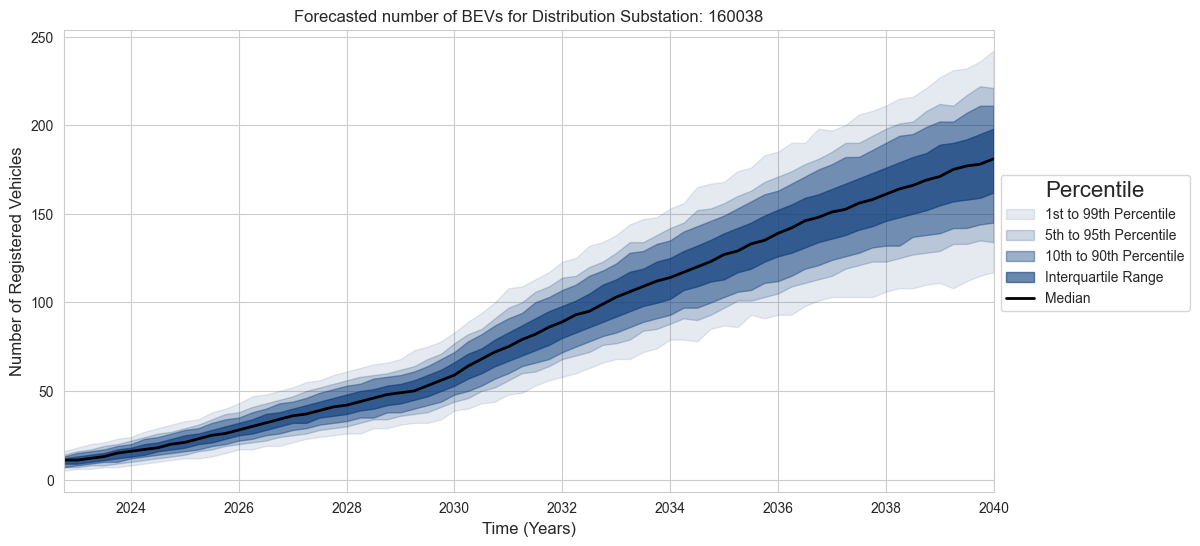

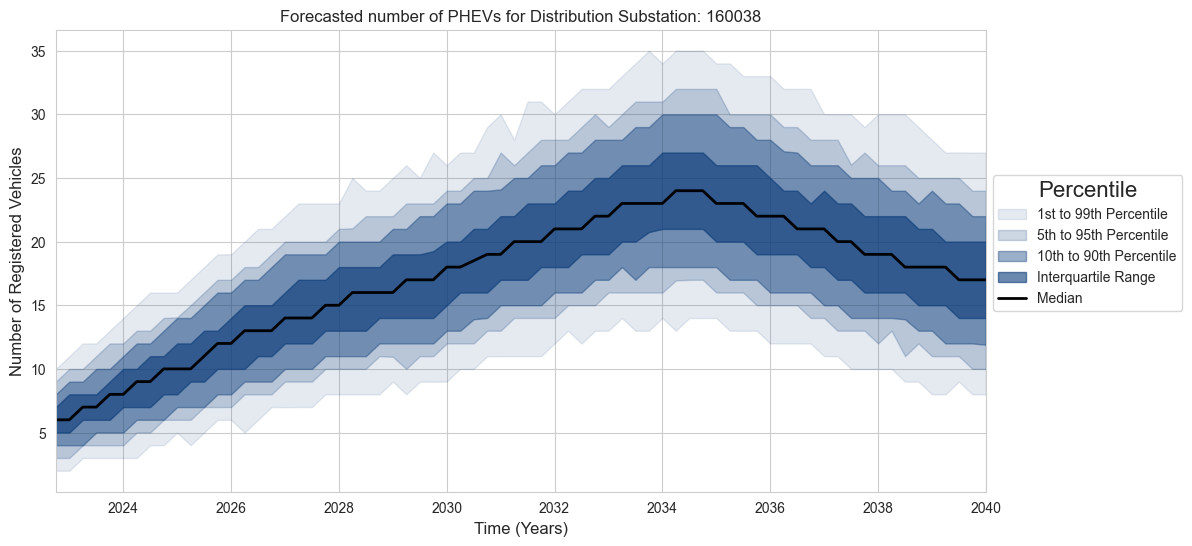

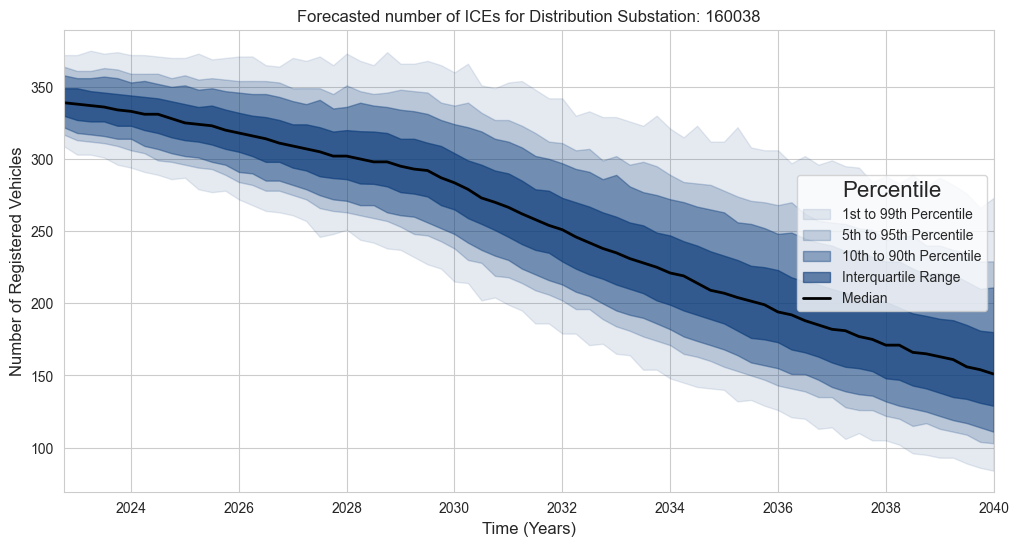

In [462]:
plot_probabilistic_vehicle_forecasts_ds(bev_forecast_ds, 'BEV', horizon=2040)
plot_probabilistic_vehicle_forecasts_ds(phev_forecast_ds, 'PHEV', horizon=2040)
plot_probabilistic_vehicle_forecasts_ds(ice_forecast_ds, 'ICE', horizon=2040)